## Counters

* [`/agas{locality#*/total}/count/bind_gid`](#Bind-GID)
* [`/agas{locality#*/total}/count/unbind_gid`](#Unbind-GID)
* [`/agas{locality#*/total}/count/resolve_gid`](#Resolve-GID)
* [`/agas{locality#*/total}/time/resolve_gid`](#Resolve-GID)
***
* [`/agas{locality#*/total}/count/route`](#Route)
* [`/agas{locality#*/total}/time/route`](#Route)
* [`/agas{locality#*/total}/count/resolve_locality`](#Resolve-Locality)
* [`/agas{locality#*/total}/time/resolve_locality`](#Resolve-Locality)
***
* [`/agas{locality#*/total}/count/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/time/decrement_credit`](#Decrement-Credit)
* [`/agas{locality#*/total}/count/increment_credit`](#Increment-Credit)
* [`/agas{locality#*/total}/time/increment_credit`](#Increment-Credit)
***
* [`/agas{locality#*/total}/count/cache/hits`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/count/cache/misses`](#AGAS-Cache-Hit-Rate)
* [`/agas{locality#*/total}/time/cache/insert_entry`](#Insert-Entry)
* [`/agas{locality#*/total}/count/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/update_entry`](#Update-Entry)
* [`/agas{locality#*/total}/time/cache/get_entry`](#Get-Entry)
* [`/agas{locality#*/total}/time/cache/erase_entry`](#Erase-Entry)

### Notebook Preps

In [4]:
%matplotlib inline

/home/nbuser/anaconda2_20/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
import sys
import os

In [6]:
import re
import itertools as it
import operator as op

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [27]:
from pprint import pprint

In [48]:
from azureml import Workspace

ws = Workspace()
cori_data = ws.datasets['cori.zip']

IndexError: A data set named "cori.zip" does not exist

In [ ]:
from zipfile import ZipFile
from cStringIO import StringIO
zf_data = StringIO(cori_data.read_as_binary())

In [46]:
with ZipFile(zf_data) as zf:
    for f in zf.filelist:
        print f.filename
        print zf.read(f.filename)[:10]

startup/

startup/1024.txt
/agas{loca
startup/128.txt
/agas{loca
startup/256.txt
/agas{loca
startup/512.txt
/agas{loca
finalize/

finalize/1024.txt
/agas{loca
finalize/128.txt
/agas{loca
finalize/256.txt
/agas{loca
finalize/512.txt
/agas{loca


---

## Performance Counter Parsing RegEx

In [6]:
pfx_pattern = re.compile(
    '/([a-z_]+){locality#(\d+)/total}/(?:(?:(count|time)/)'
    '([a-z/_-]+)|([a-z/_-]+)/(?:(count|time)))'
)

## Read the Data Files

Data is grouped in the following order:

* Subsystem
    * Procedure
        * Measure
            * Number of Nodes, Locality, Value

In [8]:
#scan_target_dir = 'startup'
scan_target_dir =  'finalize'

dataset = {}

cur_dir = os.path.abspath('.')
for i in os.listdir(os.path.join(cur_dir, scan_target_dir)):
    if i.endswith('.txt'):
        n_nodes = int(i[:-4])
        with open(os.path.join(os.path.join(scan_target_dir), i), 'r') as fd:
            fd_data = fd.read()
        # Alt 2
        for entry in fd_data.splitlines():
            fields = entry.split(',')
            value_has_unit = len(fields) == 6
            (e_counter, e_iteration, e_timestamp, e_time_unit, e_value) = fields[:5]
            if value_has_unit:
                e_value_unit = fields[5]
            counter_m = pfx_pattern.match(e_counter)
            if not counter_m:
                raise Exception
            (e_subsys, e_locality, e_measure, e_proc) = counter_m.groups()[:4]
            
            entry = [e_counter, n_nodes, int(e_locality), int(e_iteration), float(e_timestamp), e_time_unit]
            if value_has_unit:
                entry += [float(e_value), e_value_unit]
            else:
                entry += [float(e_value)]
            
            # ensure_key_seq
            if not dataset:
                dataset = {}
            if not dataset.has_key(e_subsys):
                dataset[e_subsys] = {}
            if not dataset[e_subsys].has_key(e_proc):
                dataset[e_subsys][e_proc] = {}
            if not dataset[e_subsys][e_proc].has_key(e_measure):
                dataset[e_subsys][e_proc][e_measure] = []

            dataset[e_subsys][e_proc][e_measure] += [entry]

In [9]:
dataset['agas']['increment_credit']['time'][0]

['/agas{locality#0/total}/time/increment_credit',
 1024,
 0,
 2,
 42.597323,
 '[s]',
 0.0,
 '[ns]']

---

## GIDs

### Bind GID

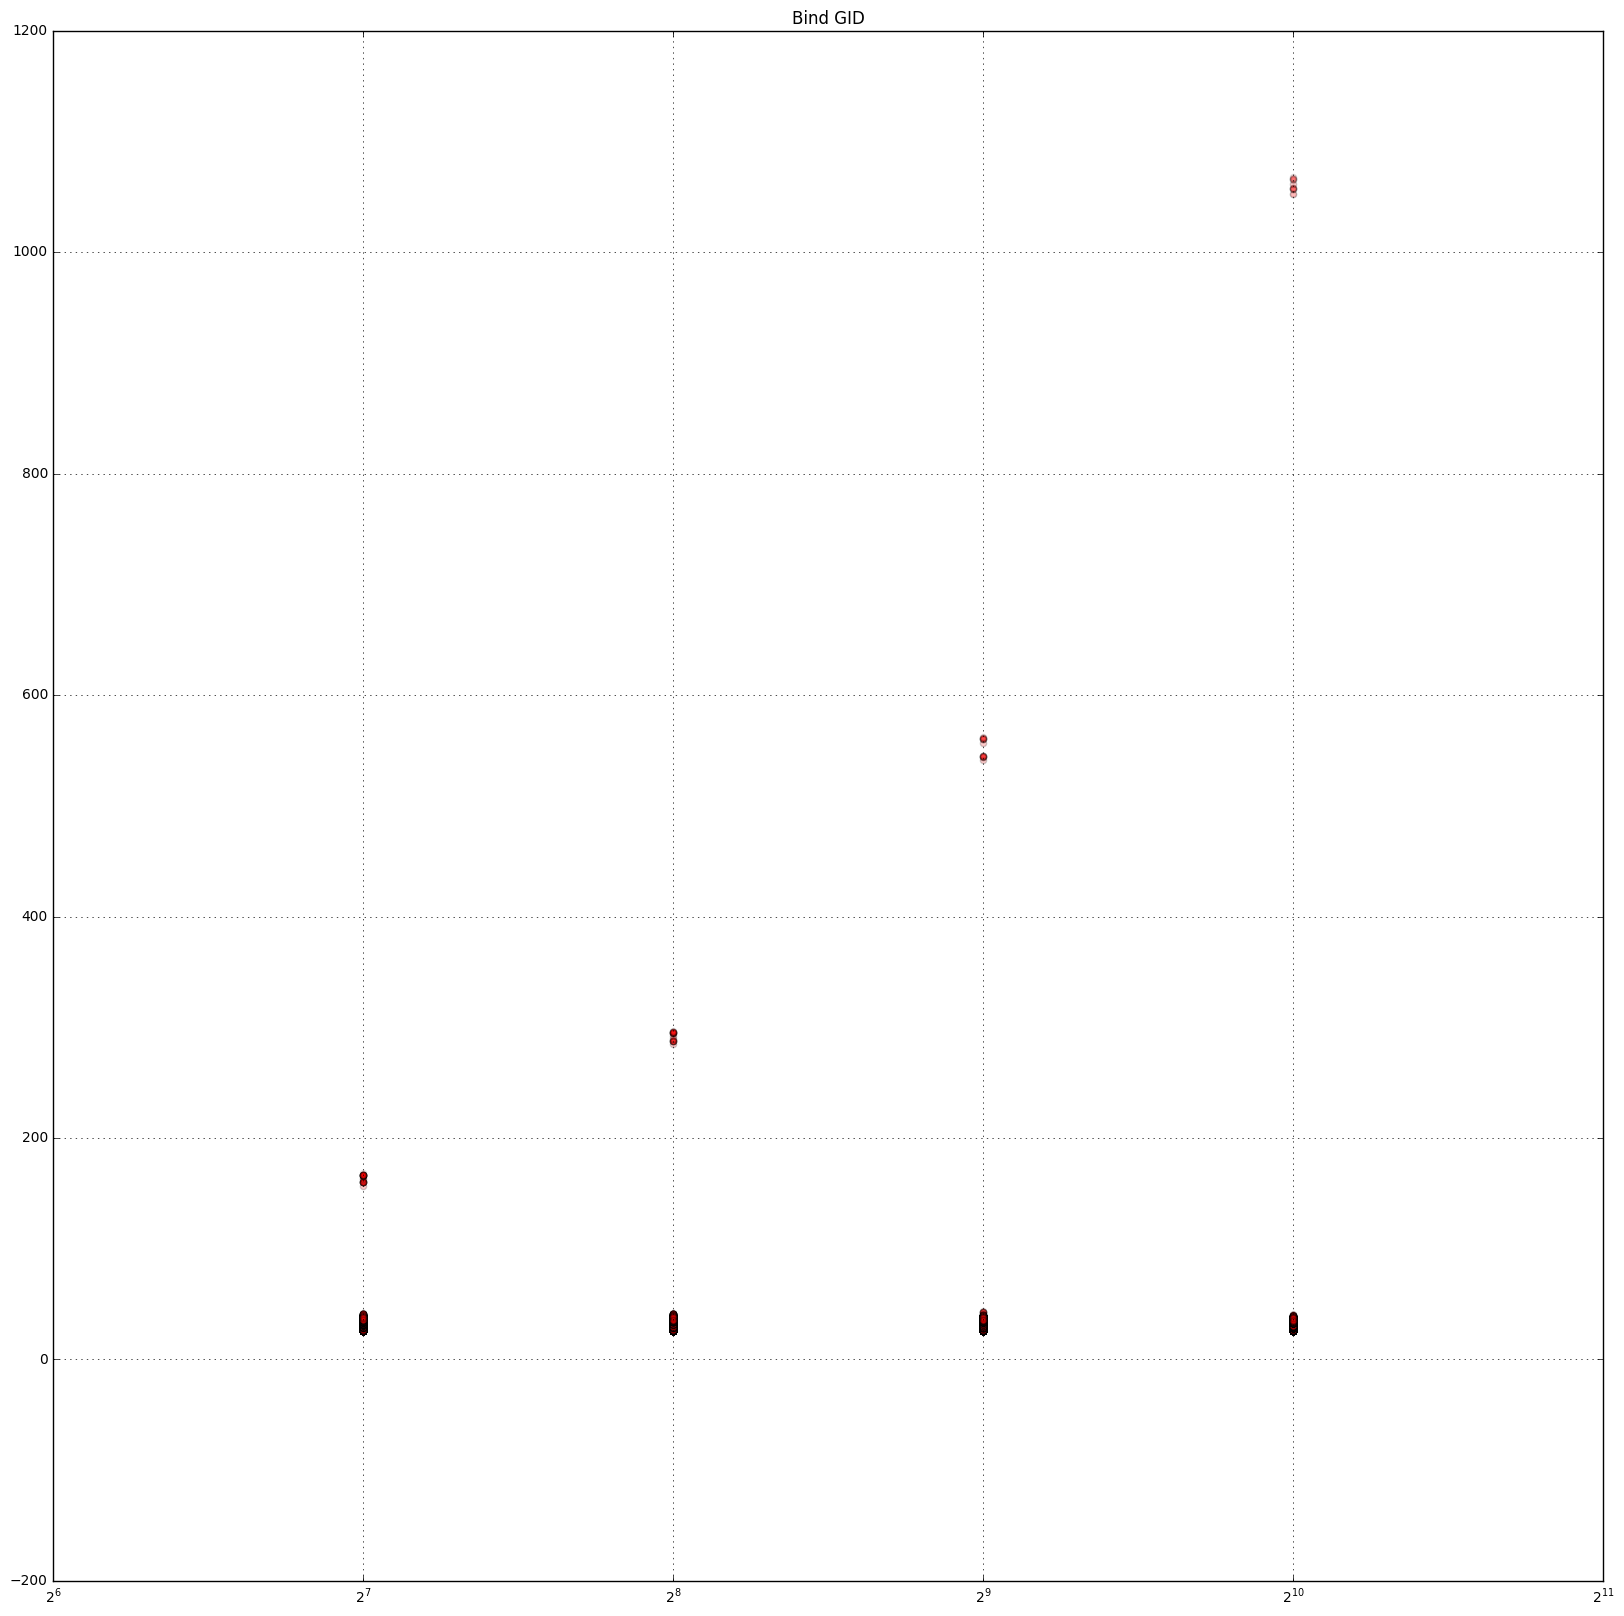

In [47]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['bind_gid']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Bind GID')
plt.xscale('log', basex=2)

#plt.figure(figsize=(20, 20))
#d = [(x[1], x[6]) for x in dataset['agas']['bind_gid']['time']]
#
#plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
#plt.grid(True)
#plt.title('Increment Credit')
#plt.xscale('log', basex=2)

### Unbind GID

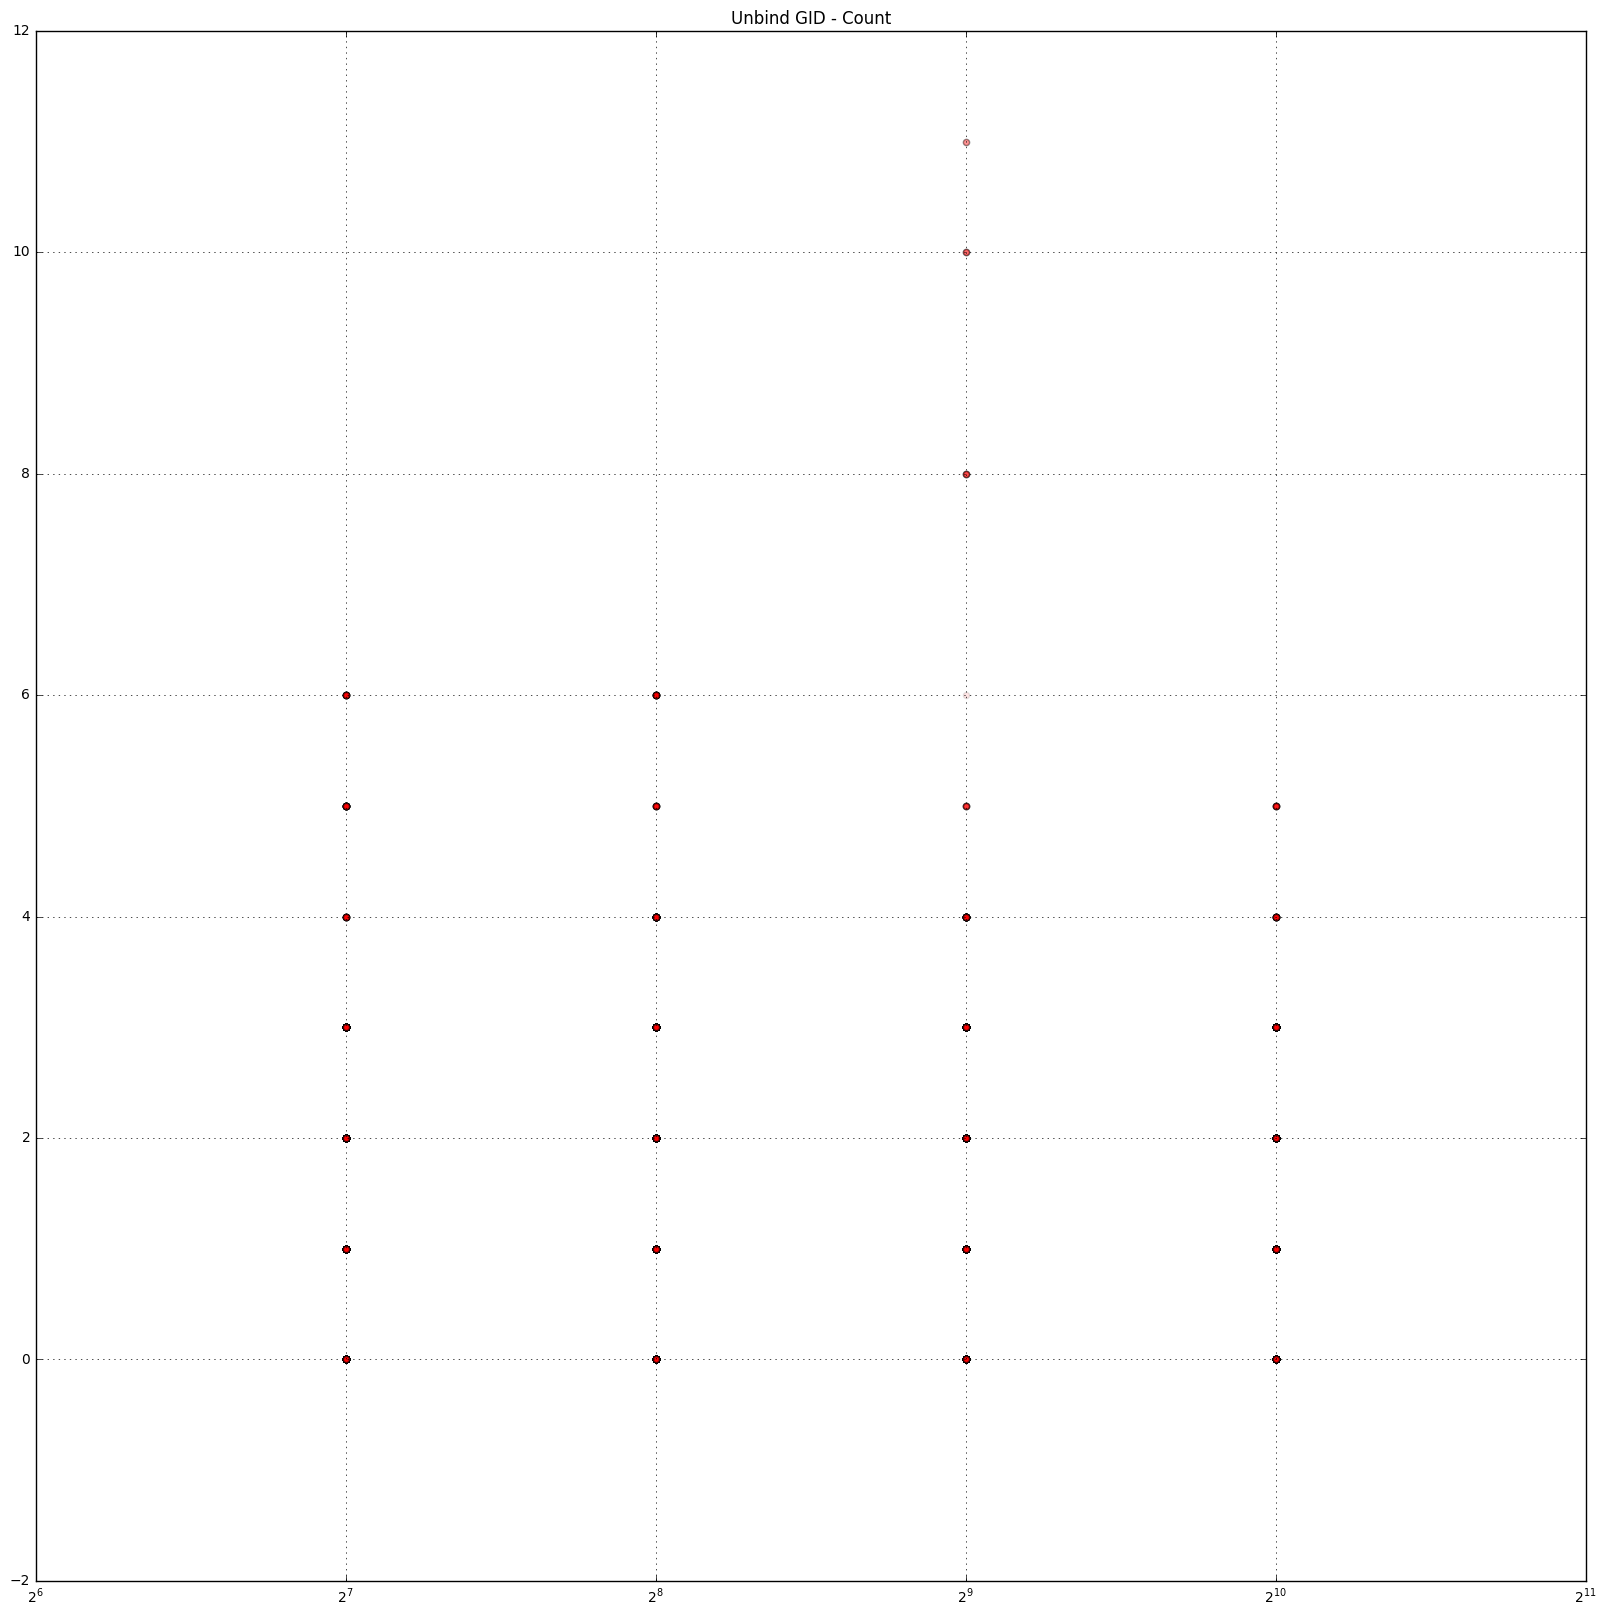

In [49]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['unbind_gid']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Unbind GID - Count')
plt.xscale('log', basex=2)

#plt.figure(figsize=(20, 20))
#d = [(x[1], x[6]) for x in dataset['agas']['unbind_gid']['time']]
#
#plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
#plt.grid(True)
#plt.title('Unbind GID - Time')
#plt.xscale('log', basex=2)

### Resolve GID

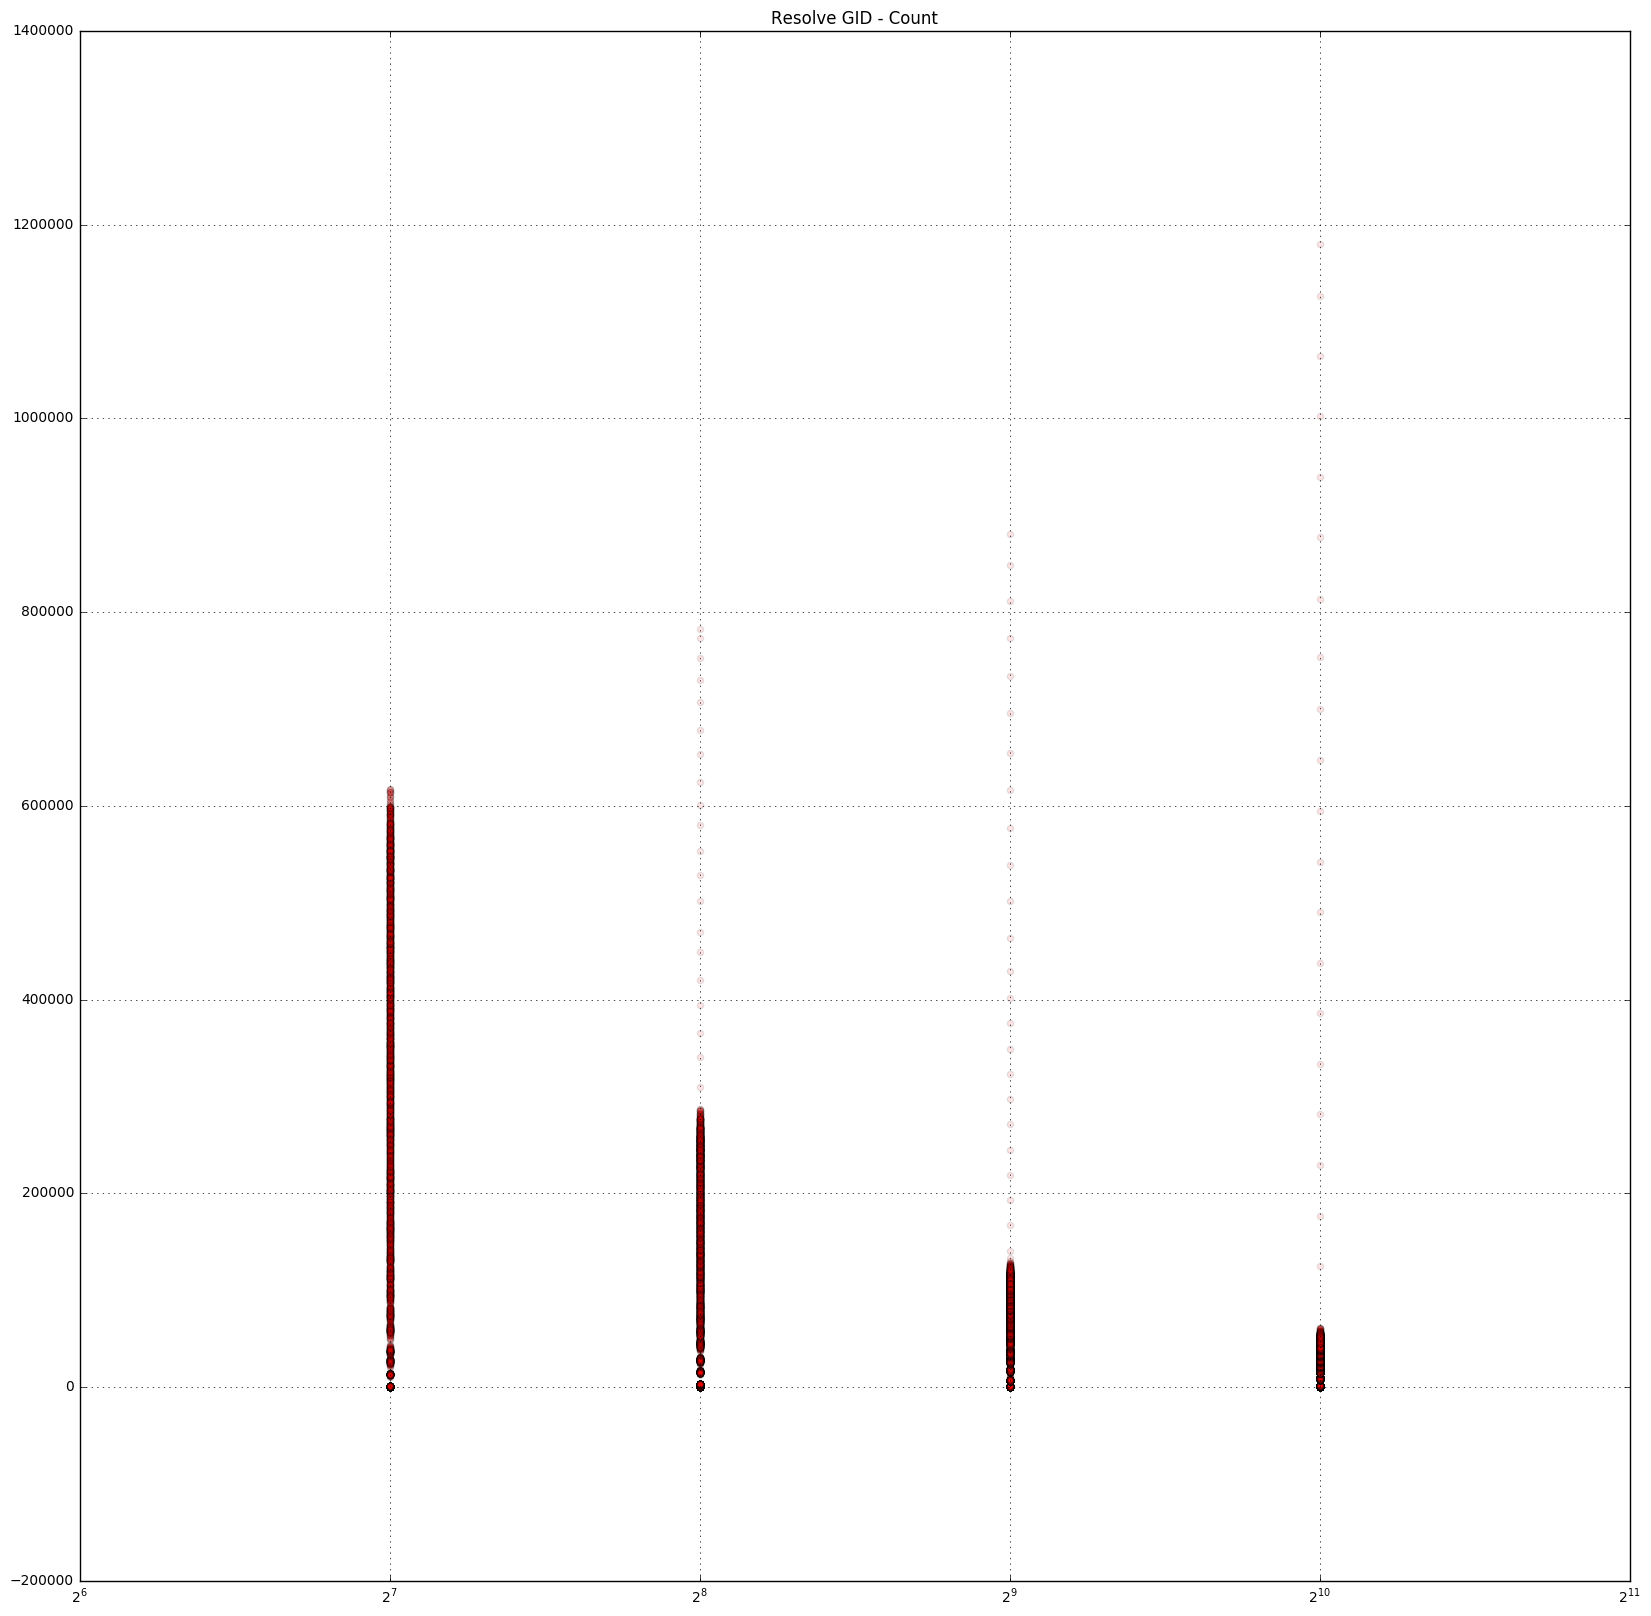

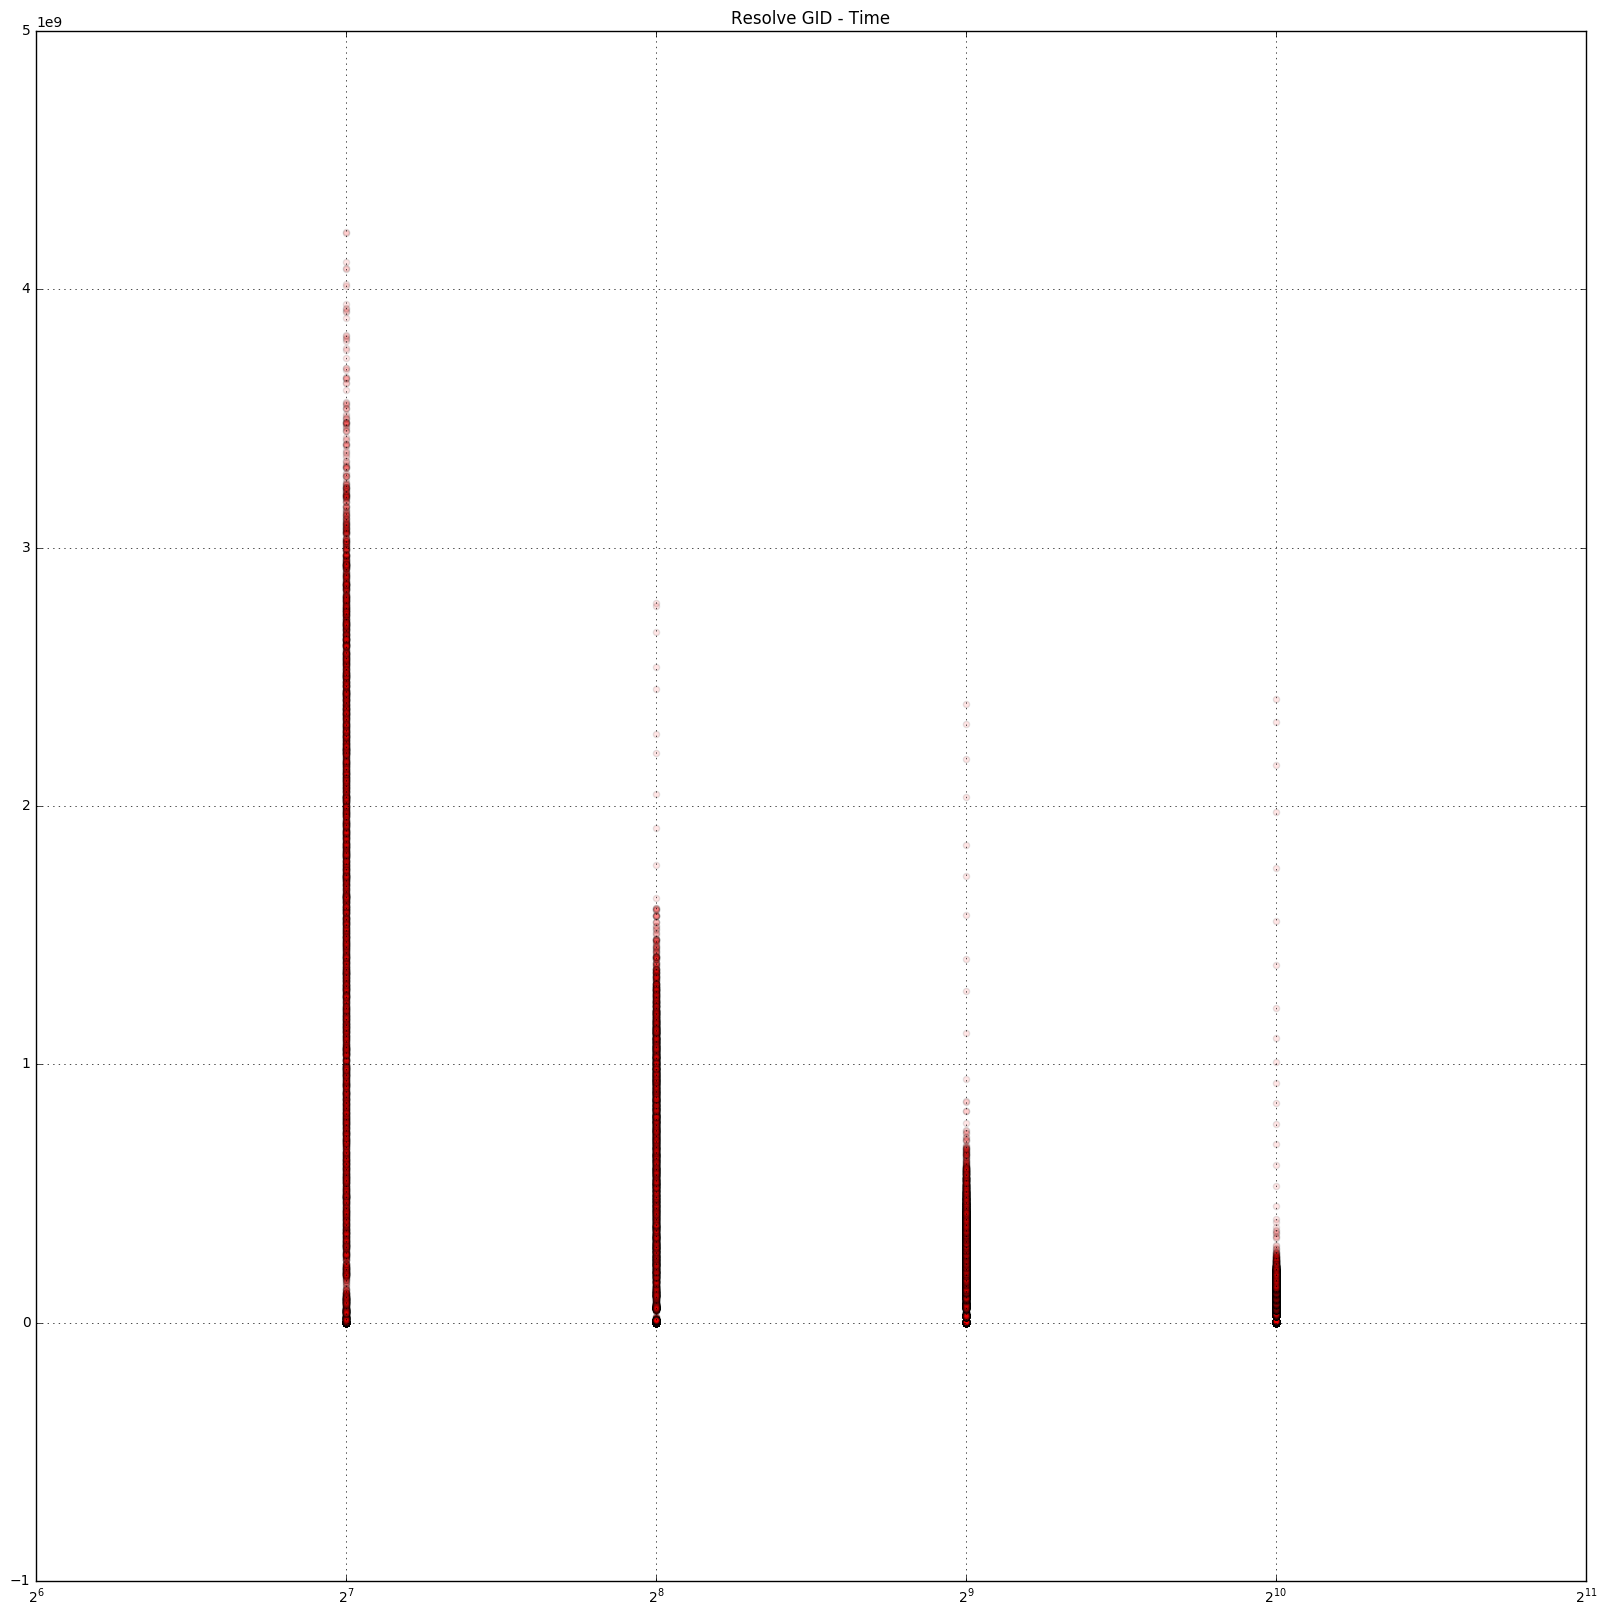

In [46]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['resolve_gid']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Resolve GID - Count')
plt.xscale('log', basex=2)

plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['resolve_gid']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Resolve GID - Time')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

---

## Locality Namespace

### Route

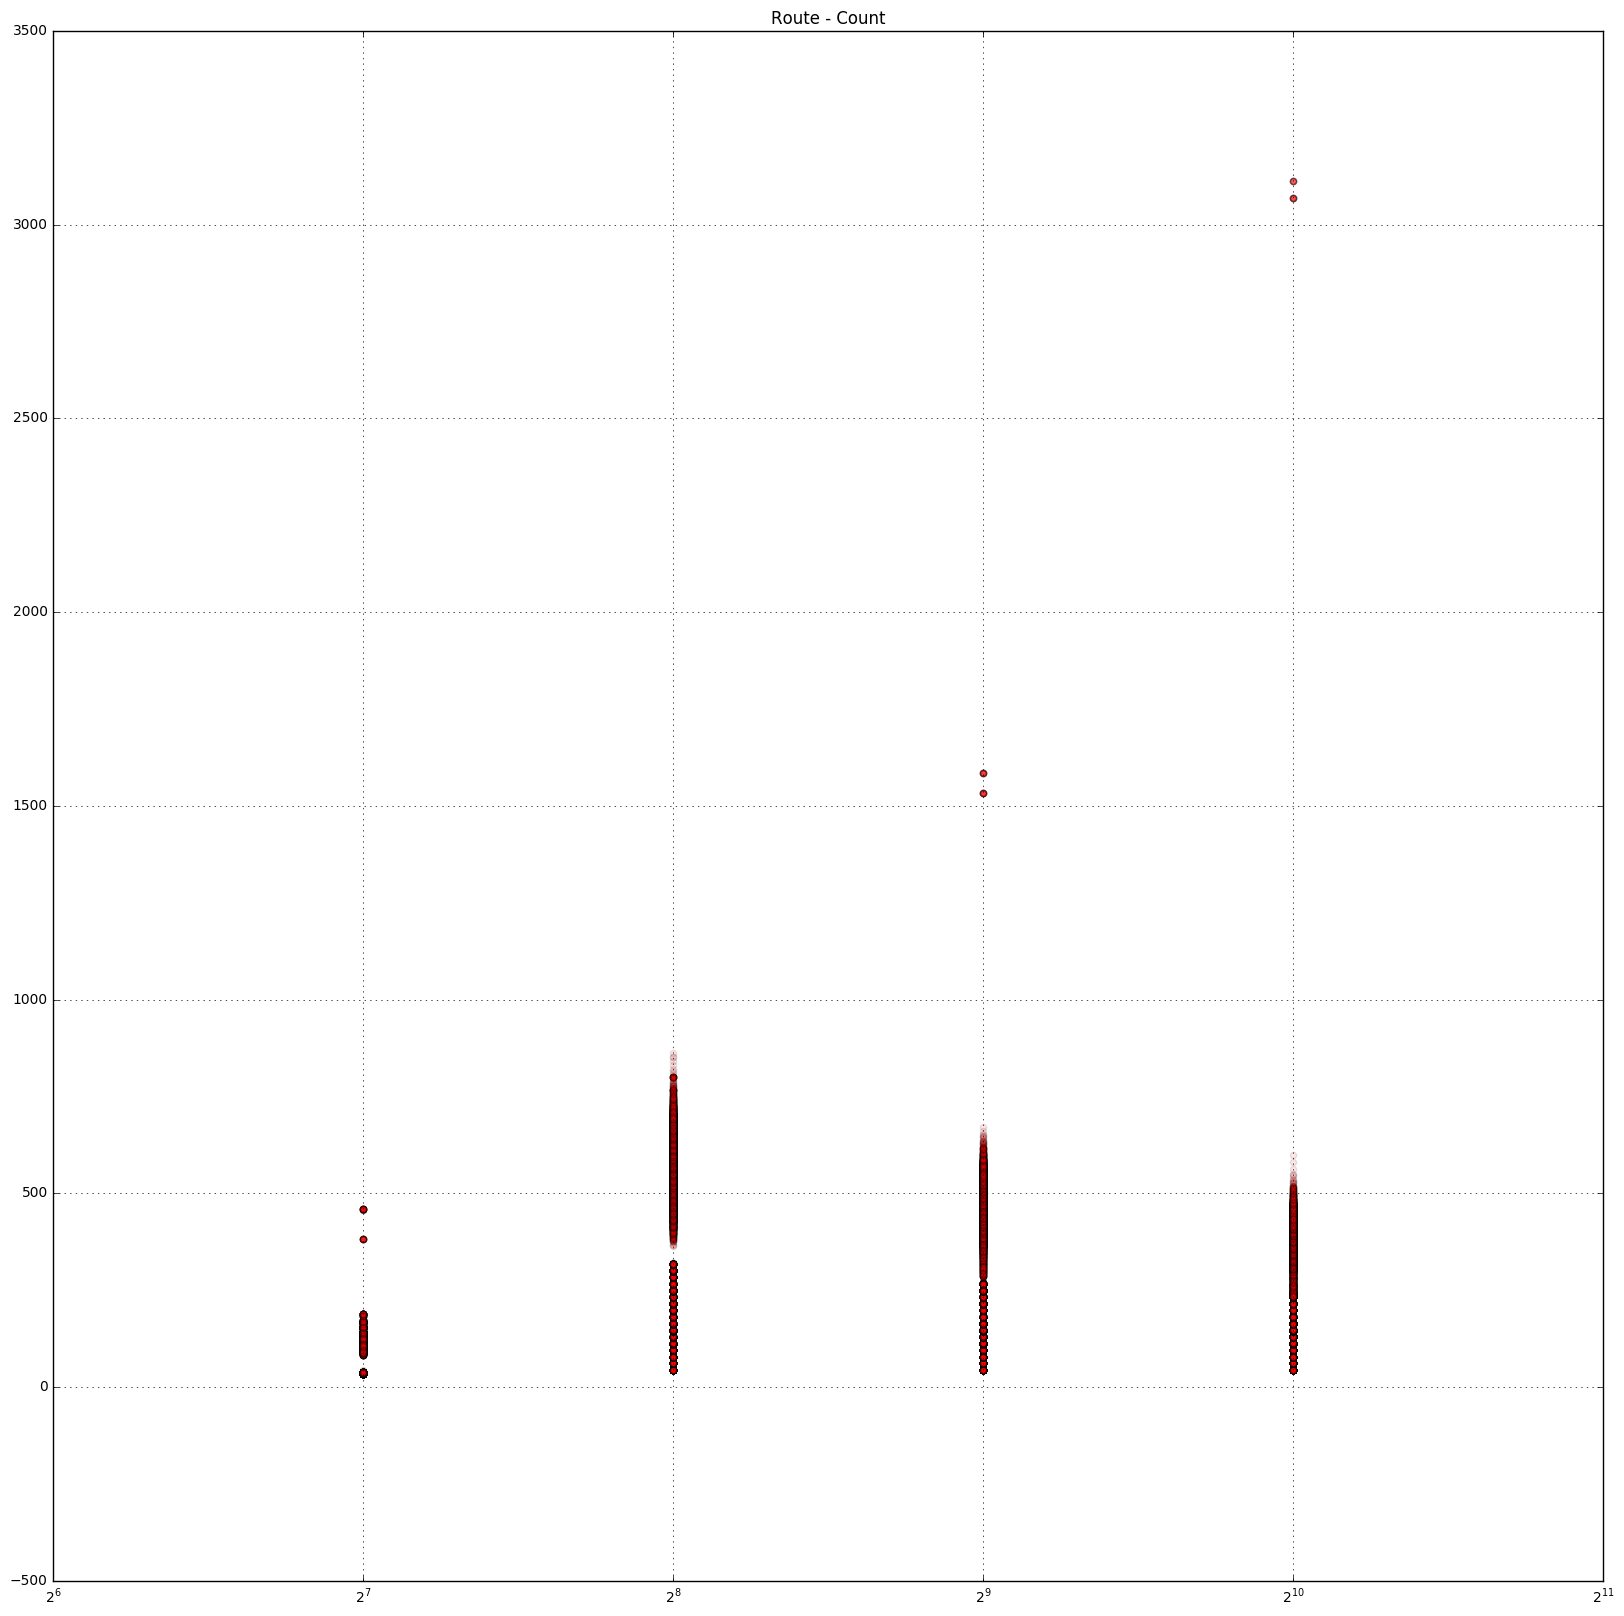

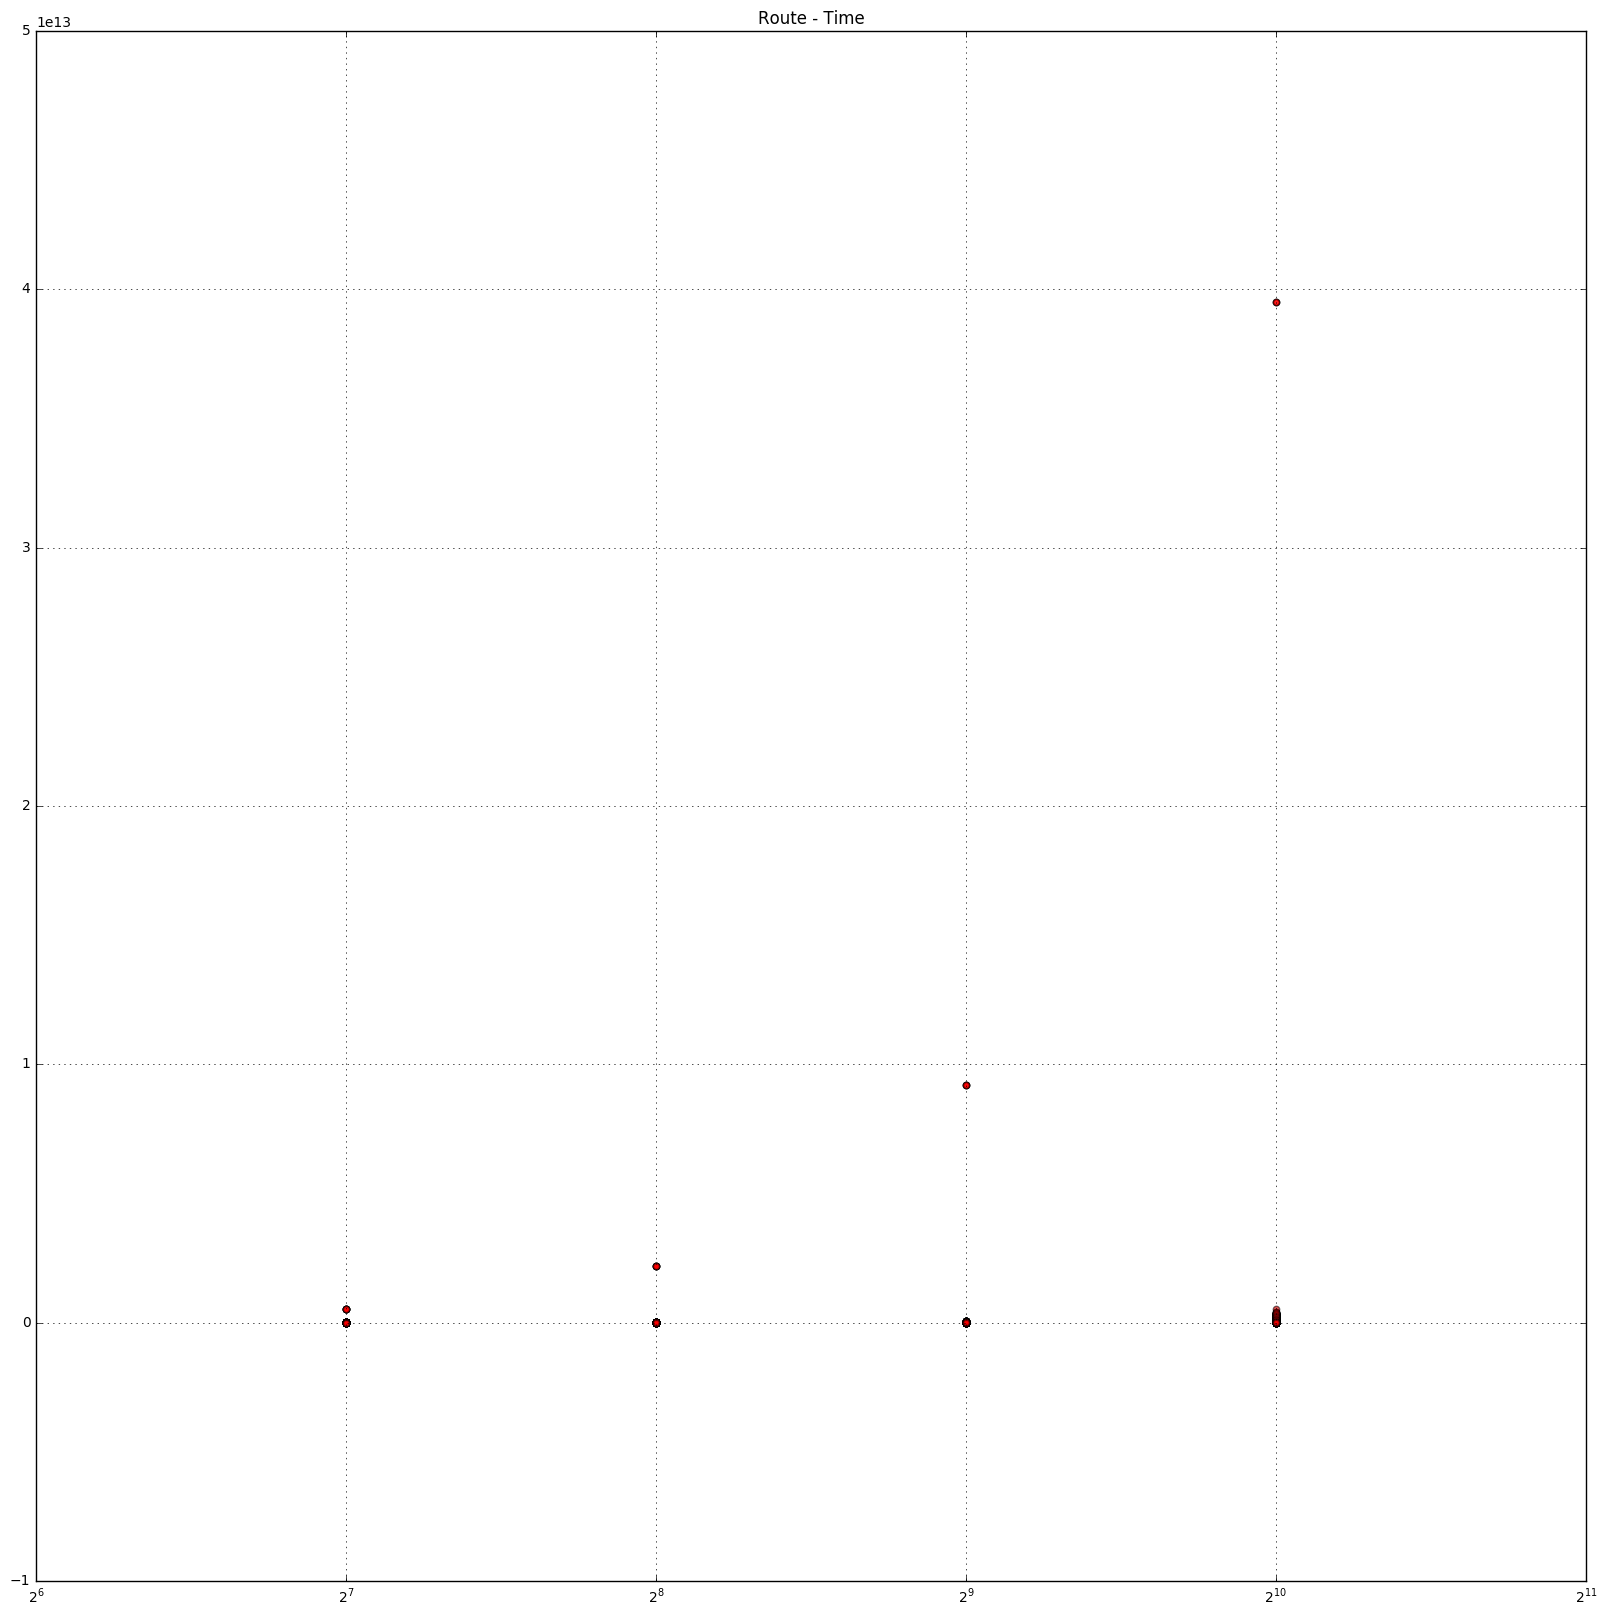

In [50]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['route']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Route - Count')
plt.xscale('log', basex=2)

plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['route']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Route - Time')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Resolve Locality

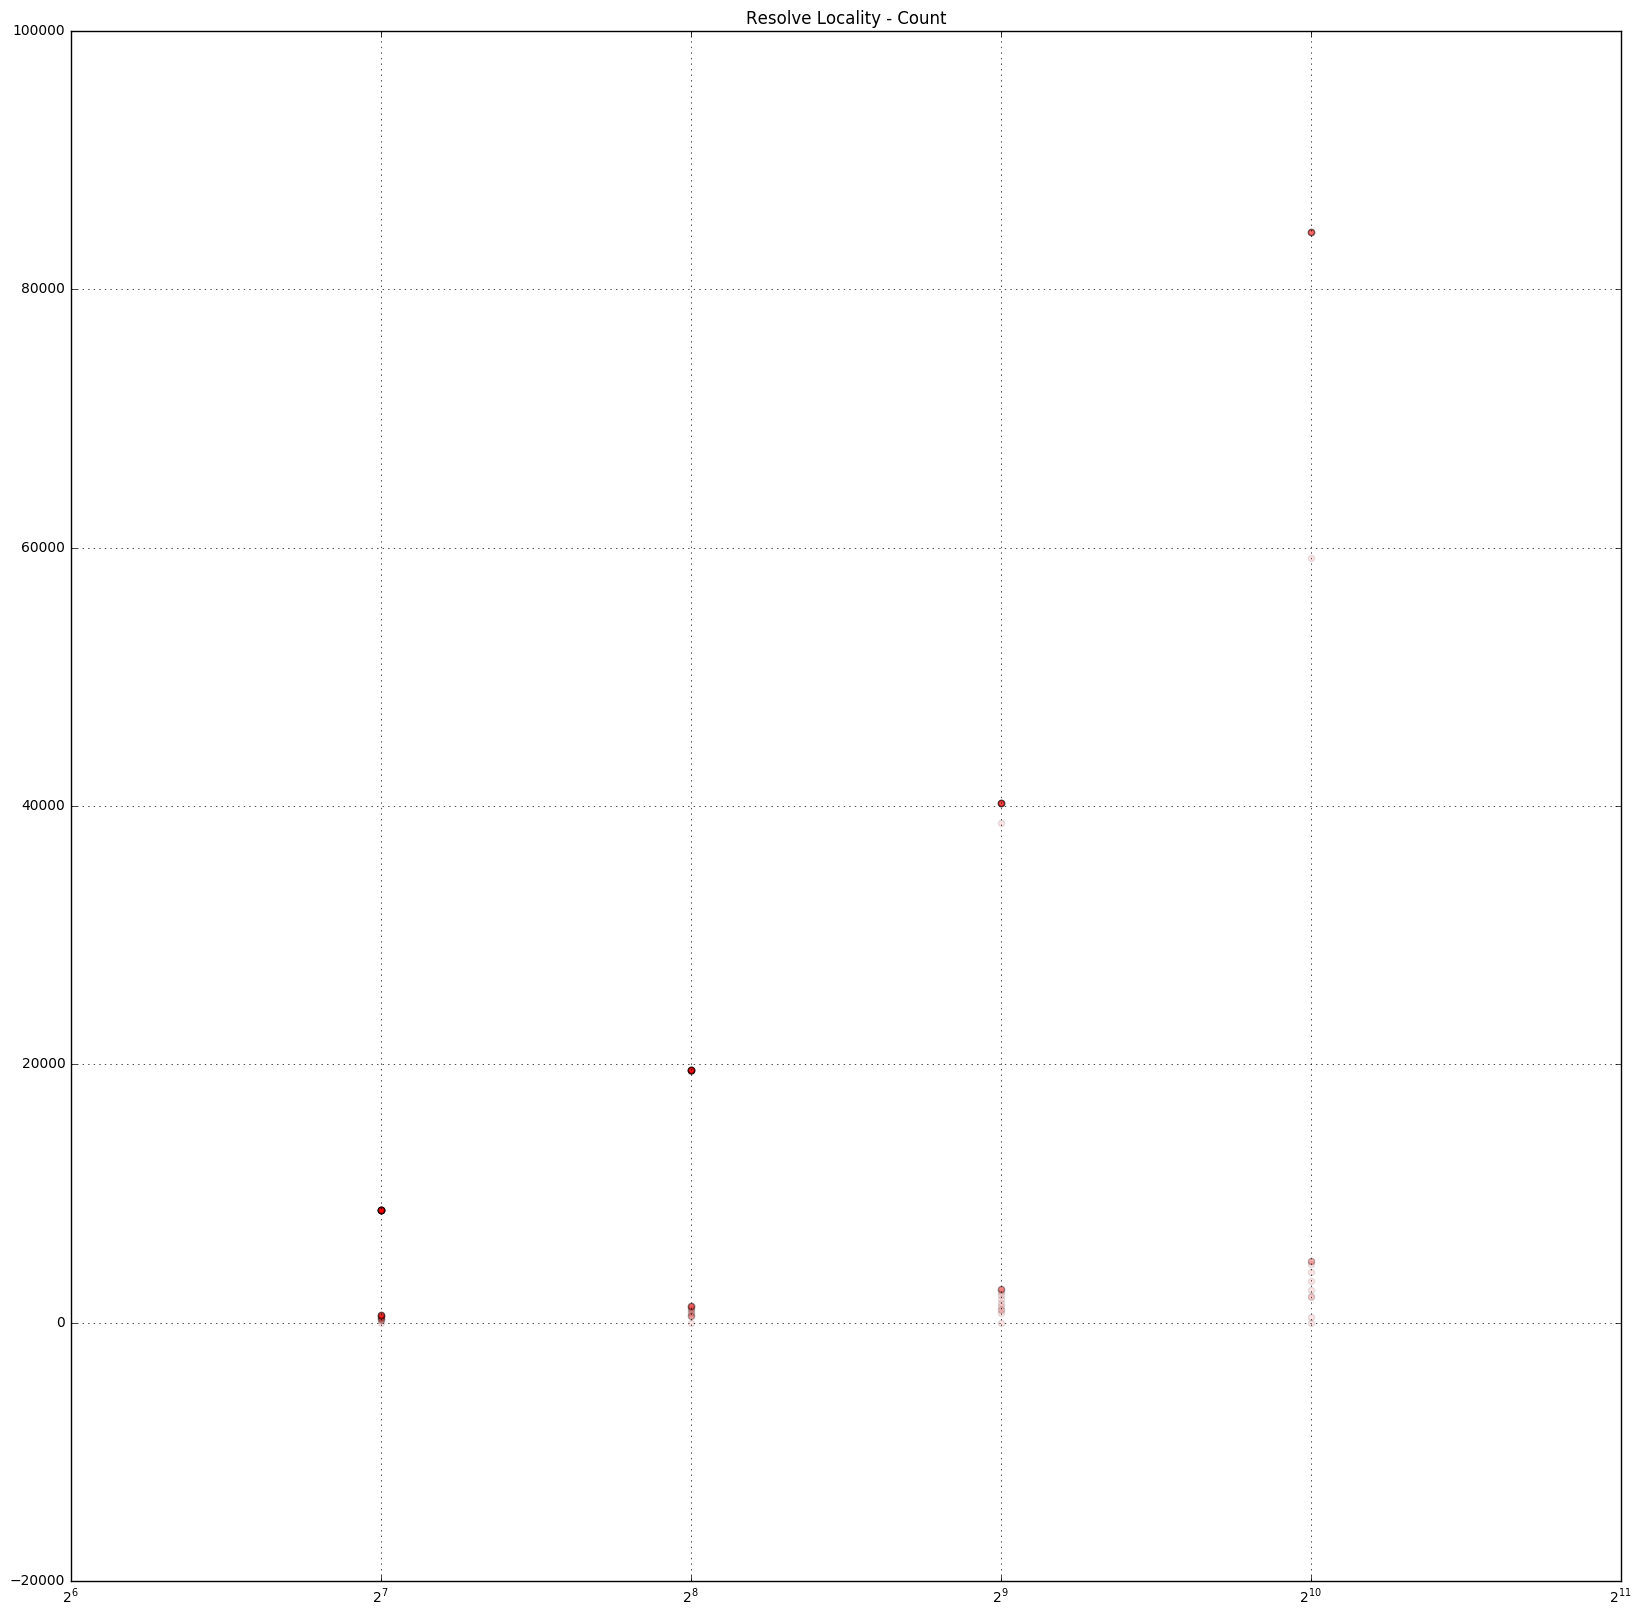

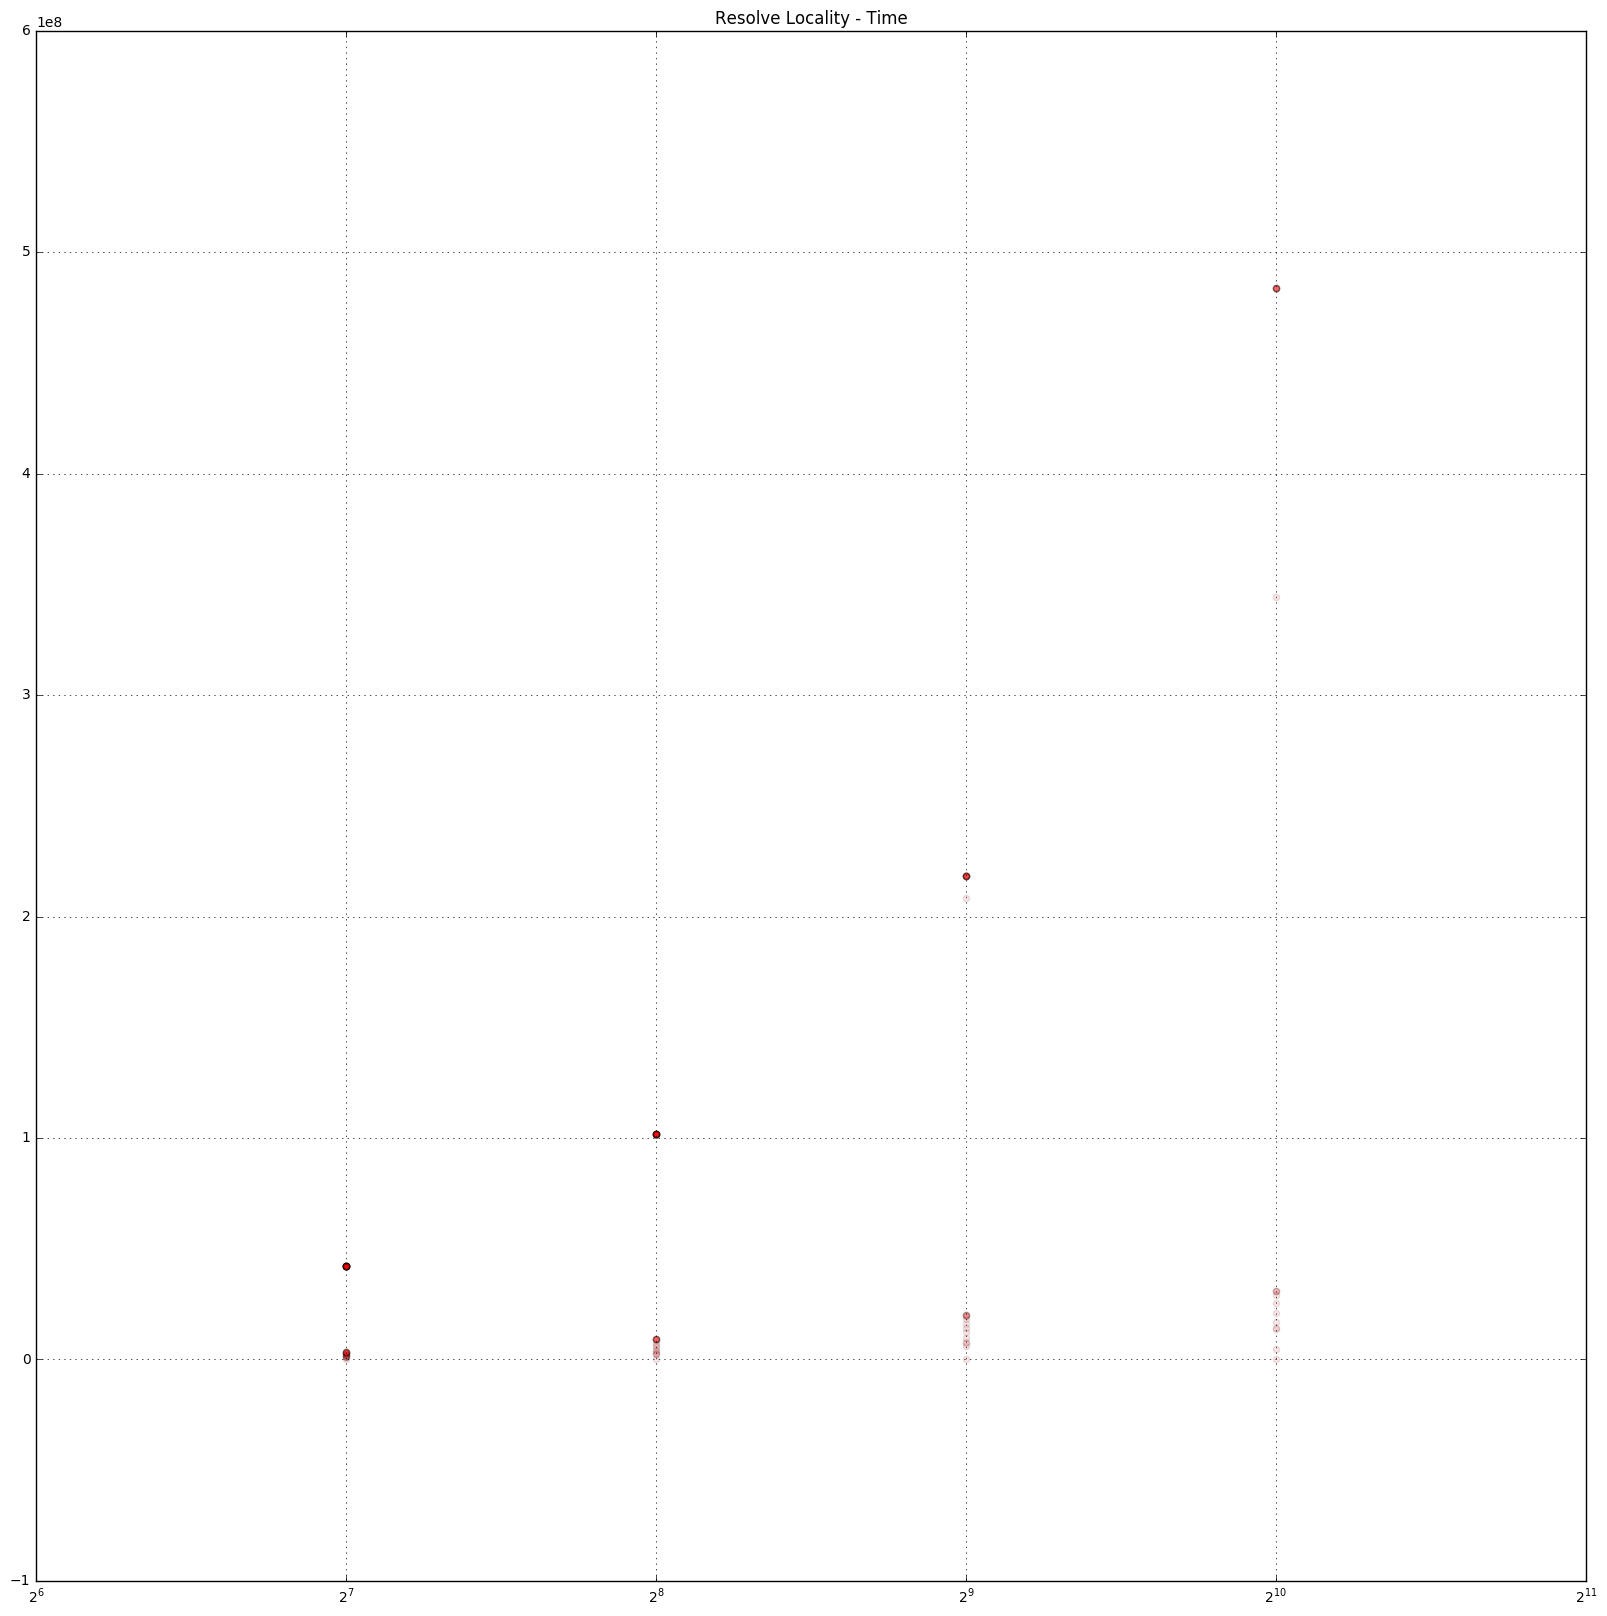

In [51]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['resolve_locality']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Resolve Locality - Count')
plt.xscale('log', basex=2)

plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['resolve_locality']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Resolve Locality - Time')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

---

## Garbage Collection

### Increment Credit

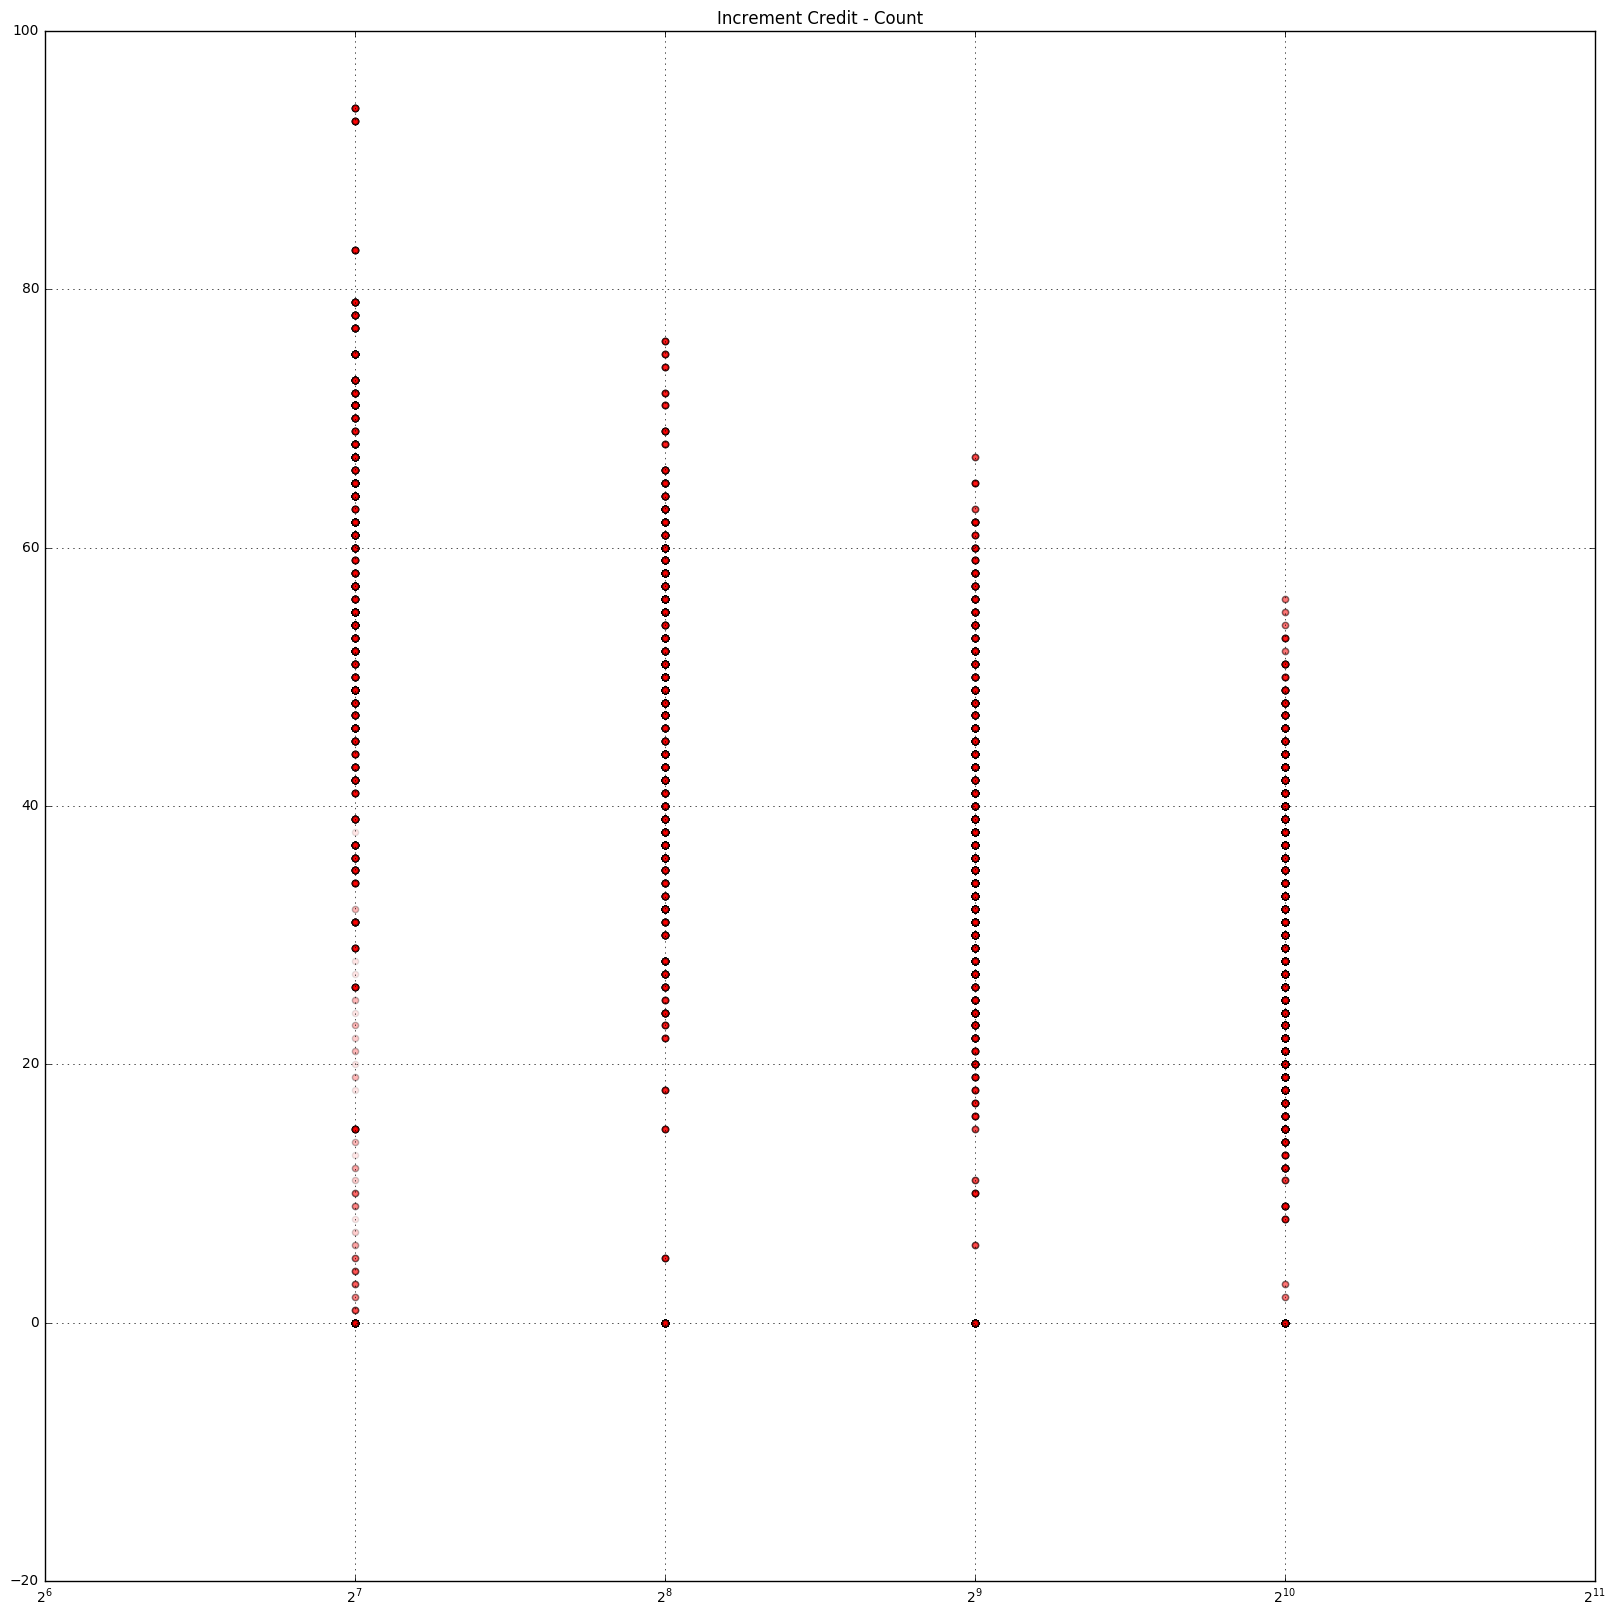

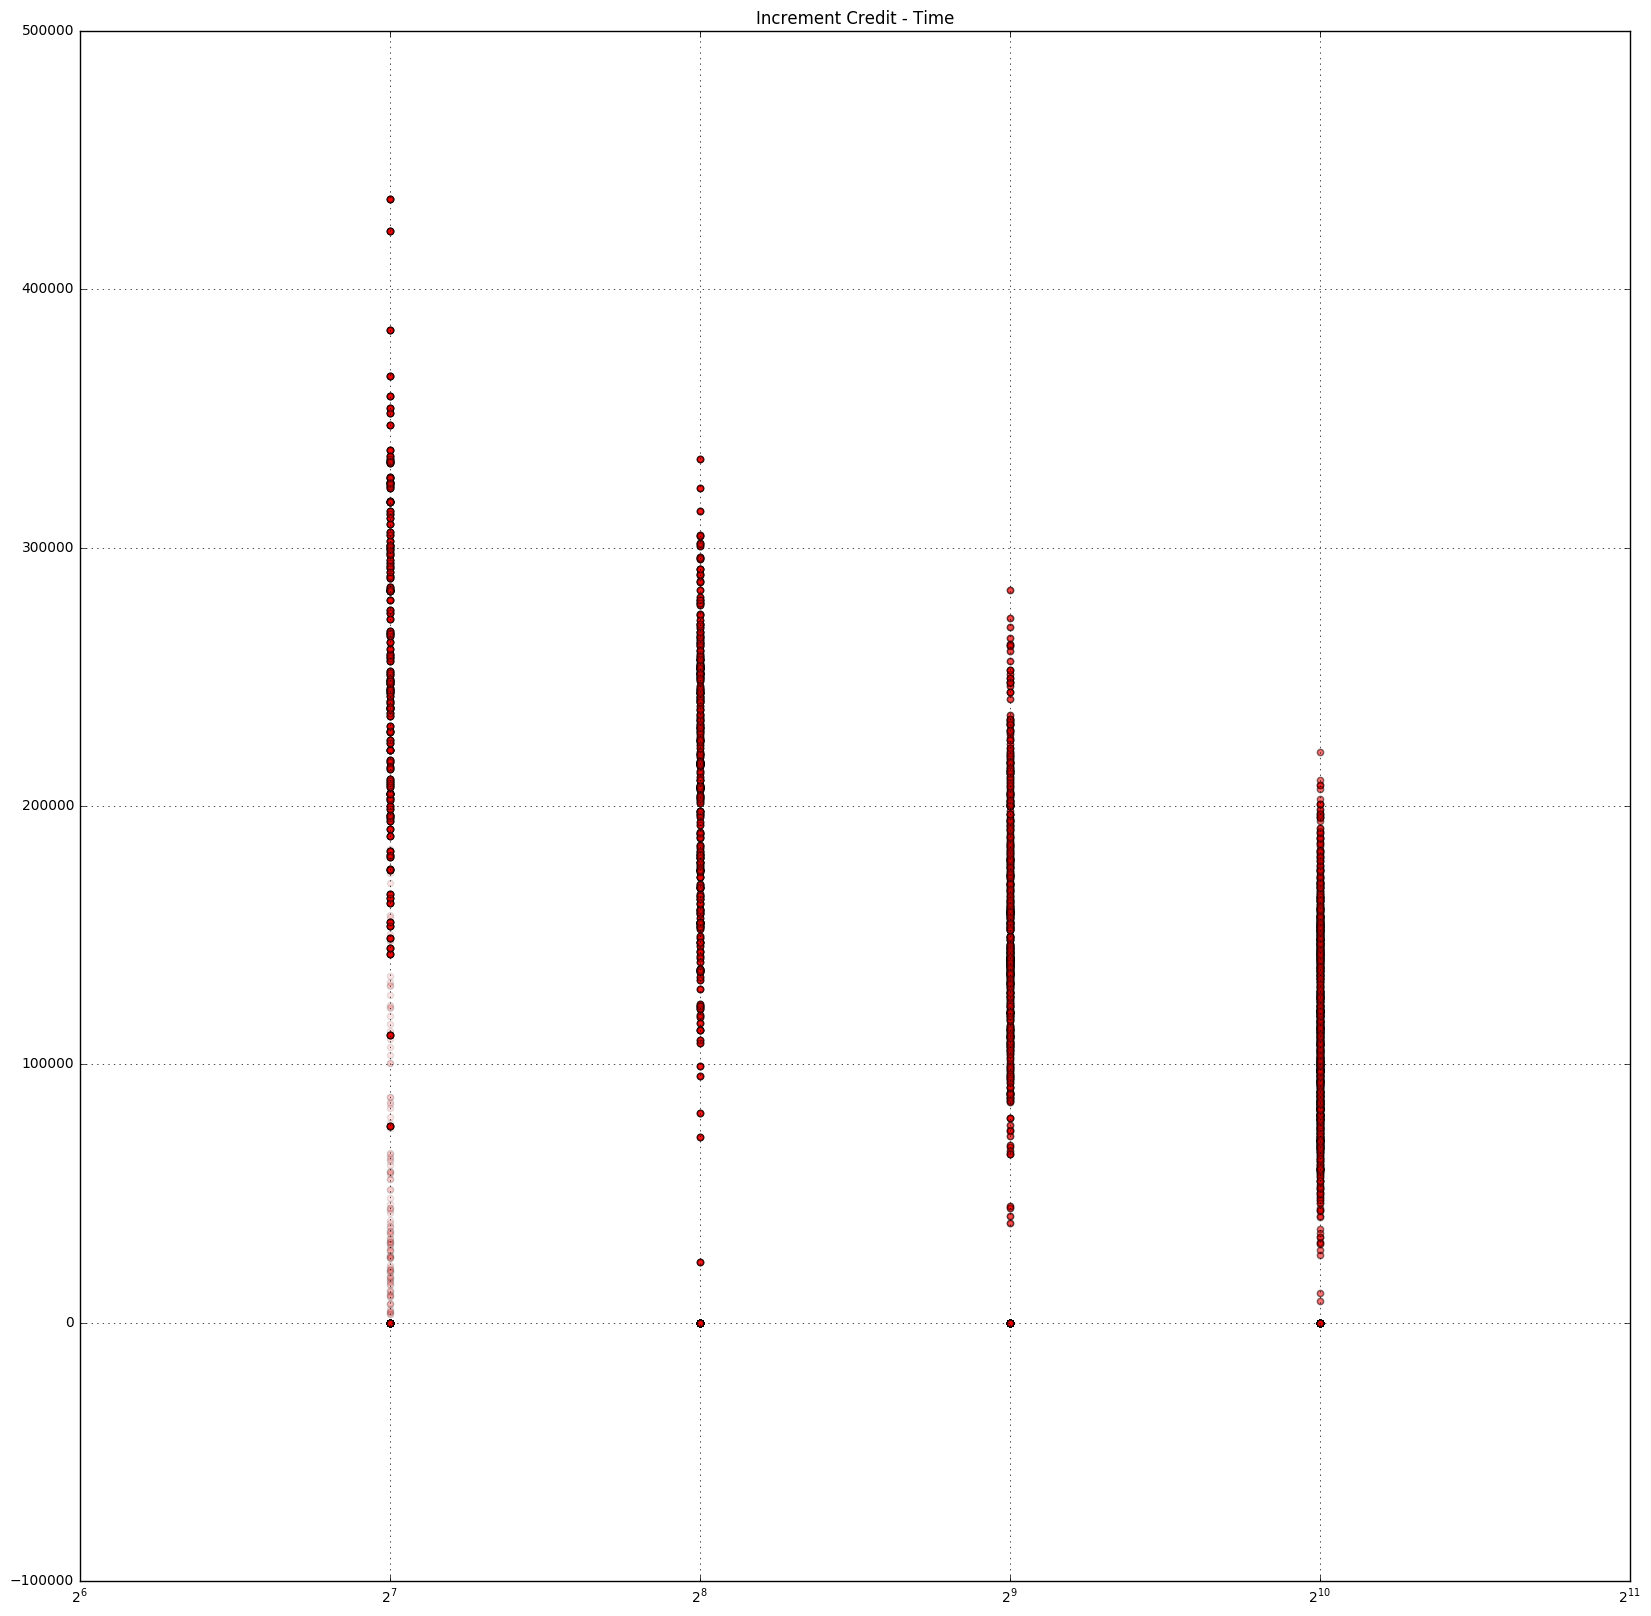

In [52]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['increment_credit']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Increment Credit - Count')
plt.xscale('log', basex=2)

plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['increment_credit']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Increment Credit - Time')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Decrement Credit

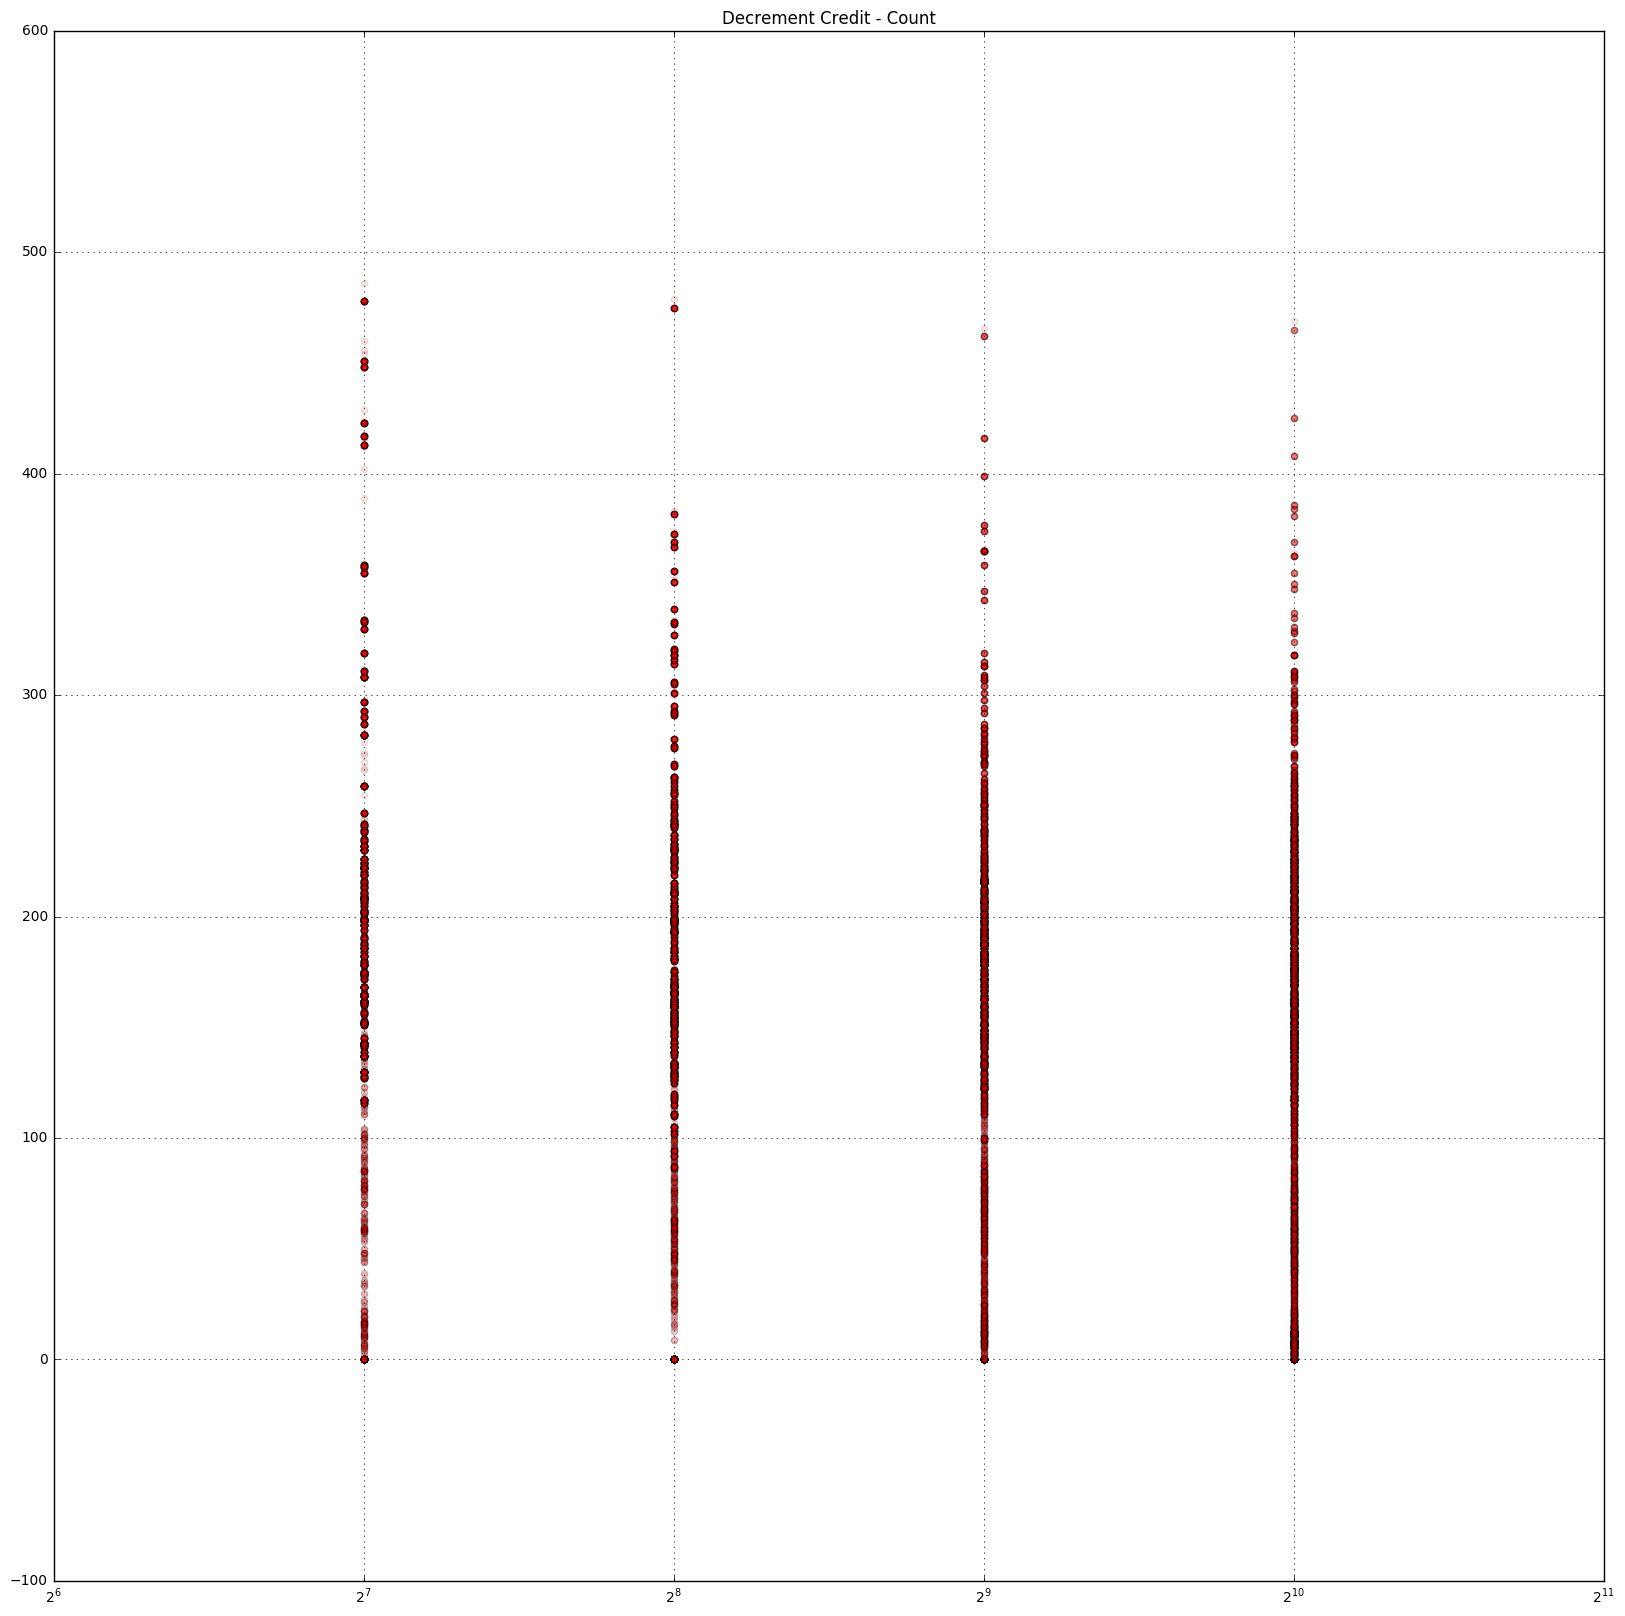

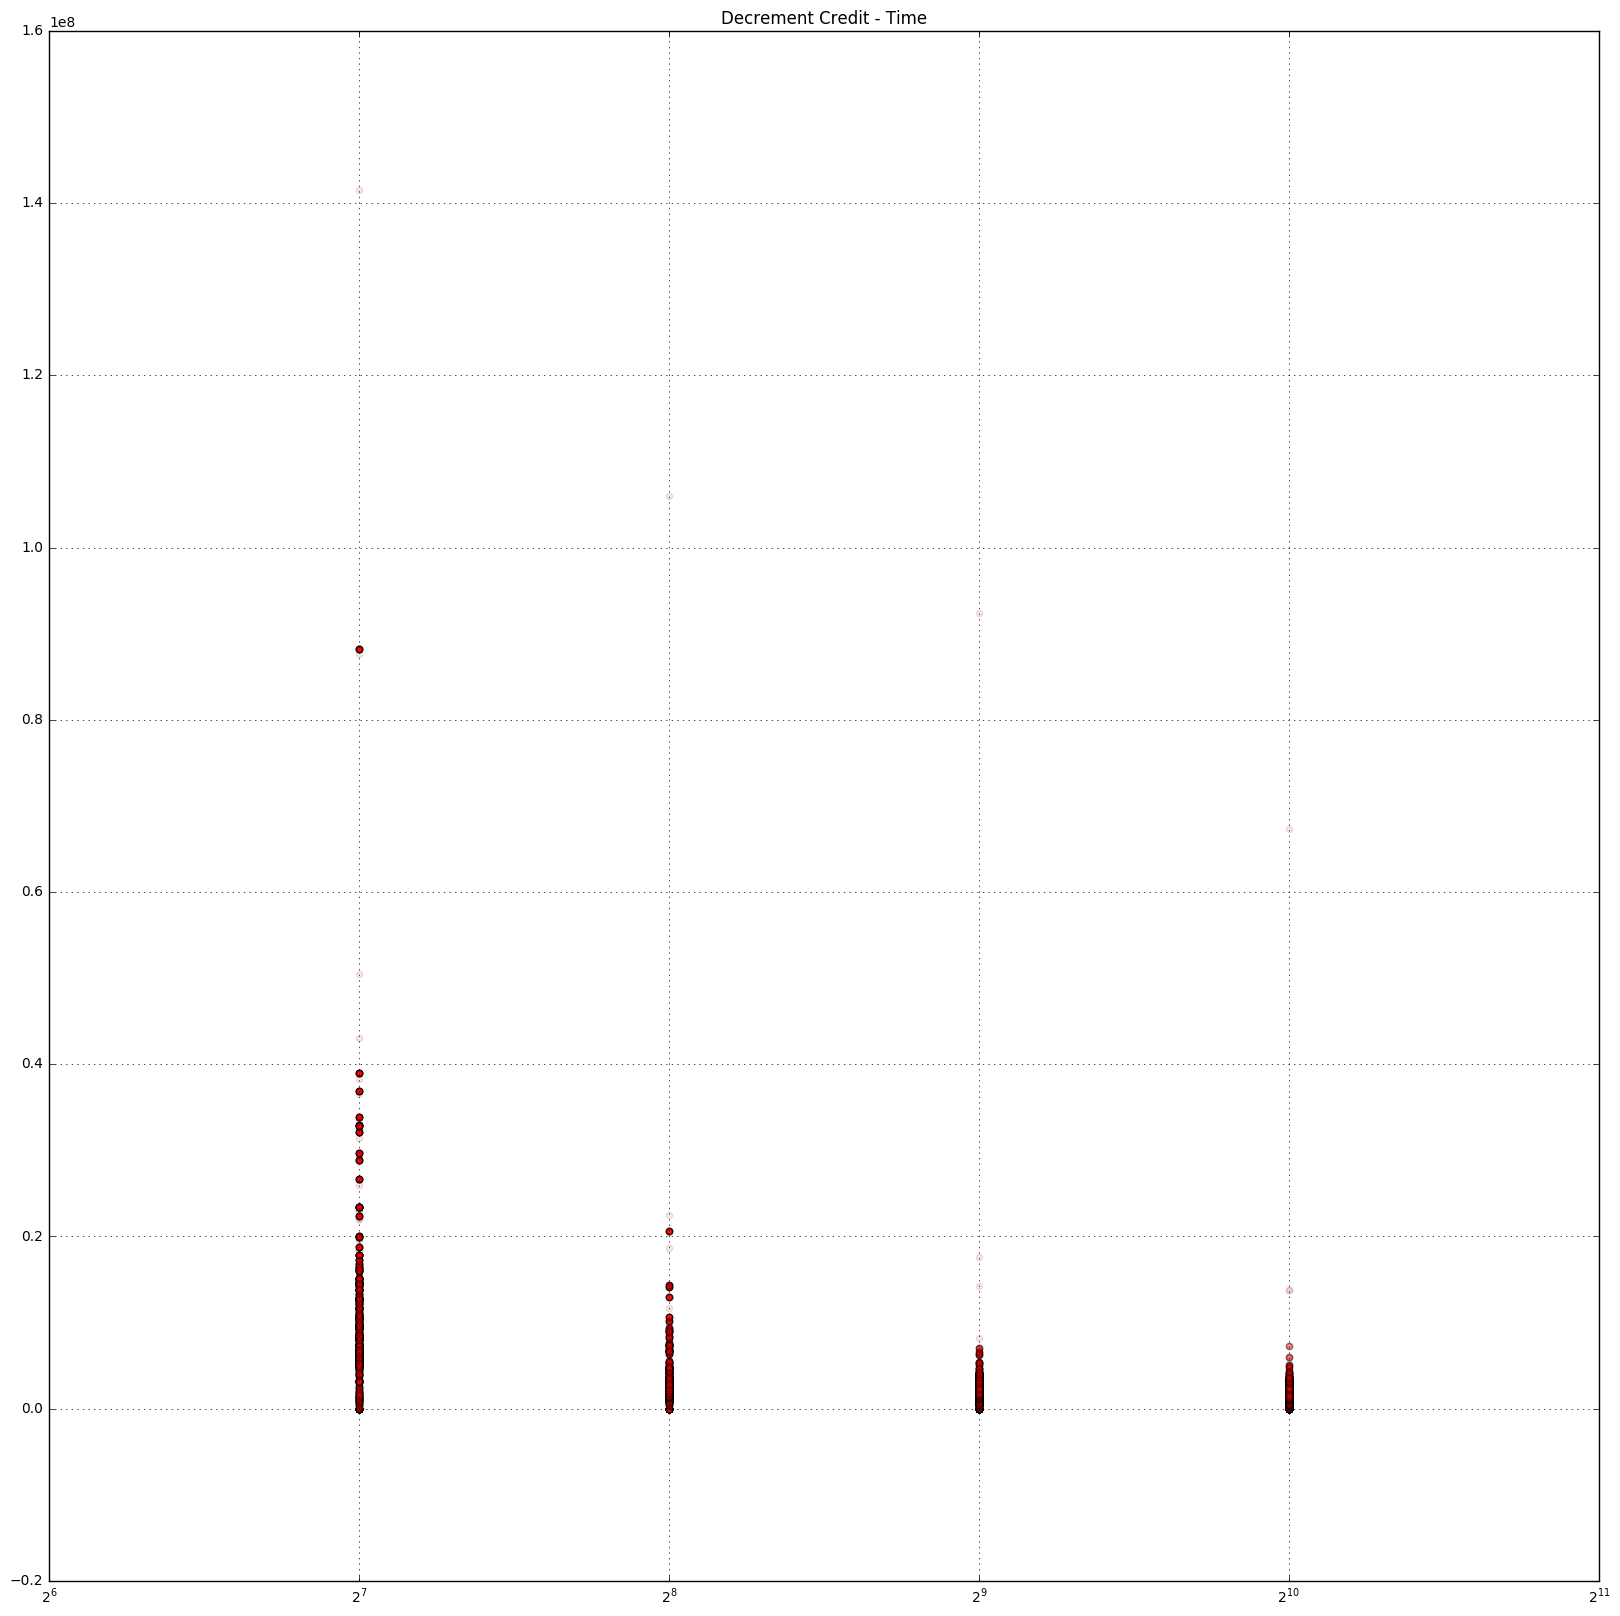

In [53]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['decrement_credit']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Decrement Credit - Count')
plt.xscale('log', basex=2)

plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['decrement_credit']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('Decrement Credit - Time')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

---

## AGAS Cache

### AGAS Cache Hit Rate

* $\textit{hits}: \mathtt{/agas\{locality\#*/total\}/count/cache/hits}$
* $\textit{misses}: \mathtt{/agas\{locality\#*/total\}/count/cache/misses}$

$$
\textit{miss rate} = \frac{\textit{misses}}{\textit{misses} + \textit{hits}}
$$

In [10]:
d = [(x[1], x[6]) for x in dataset['agas']['cache/misses']['count']]
e = [(x[1], x[6]) for x in dataset['agas']['cache/hits']['count']]
f = []
for i, j in zip(d, e):
    f += [j[1] / (i[1] + j[1])]

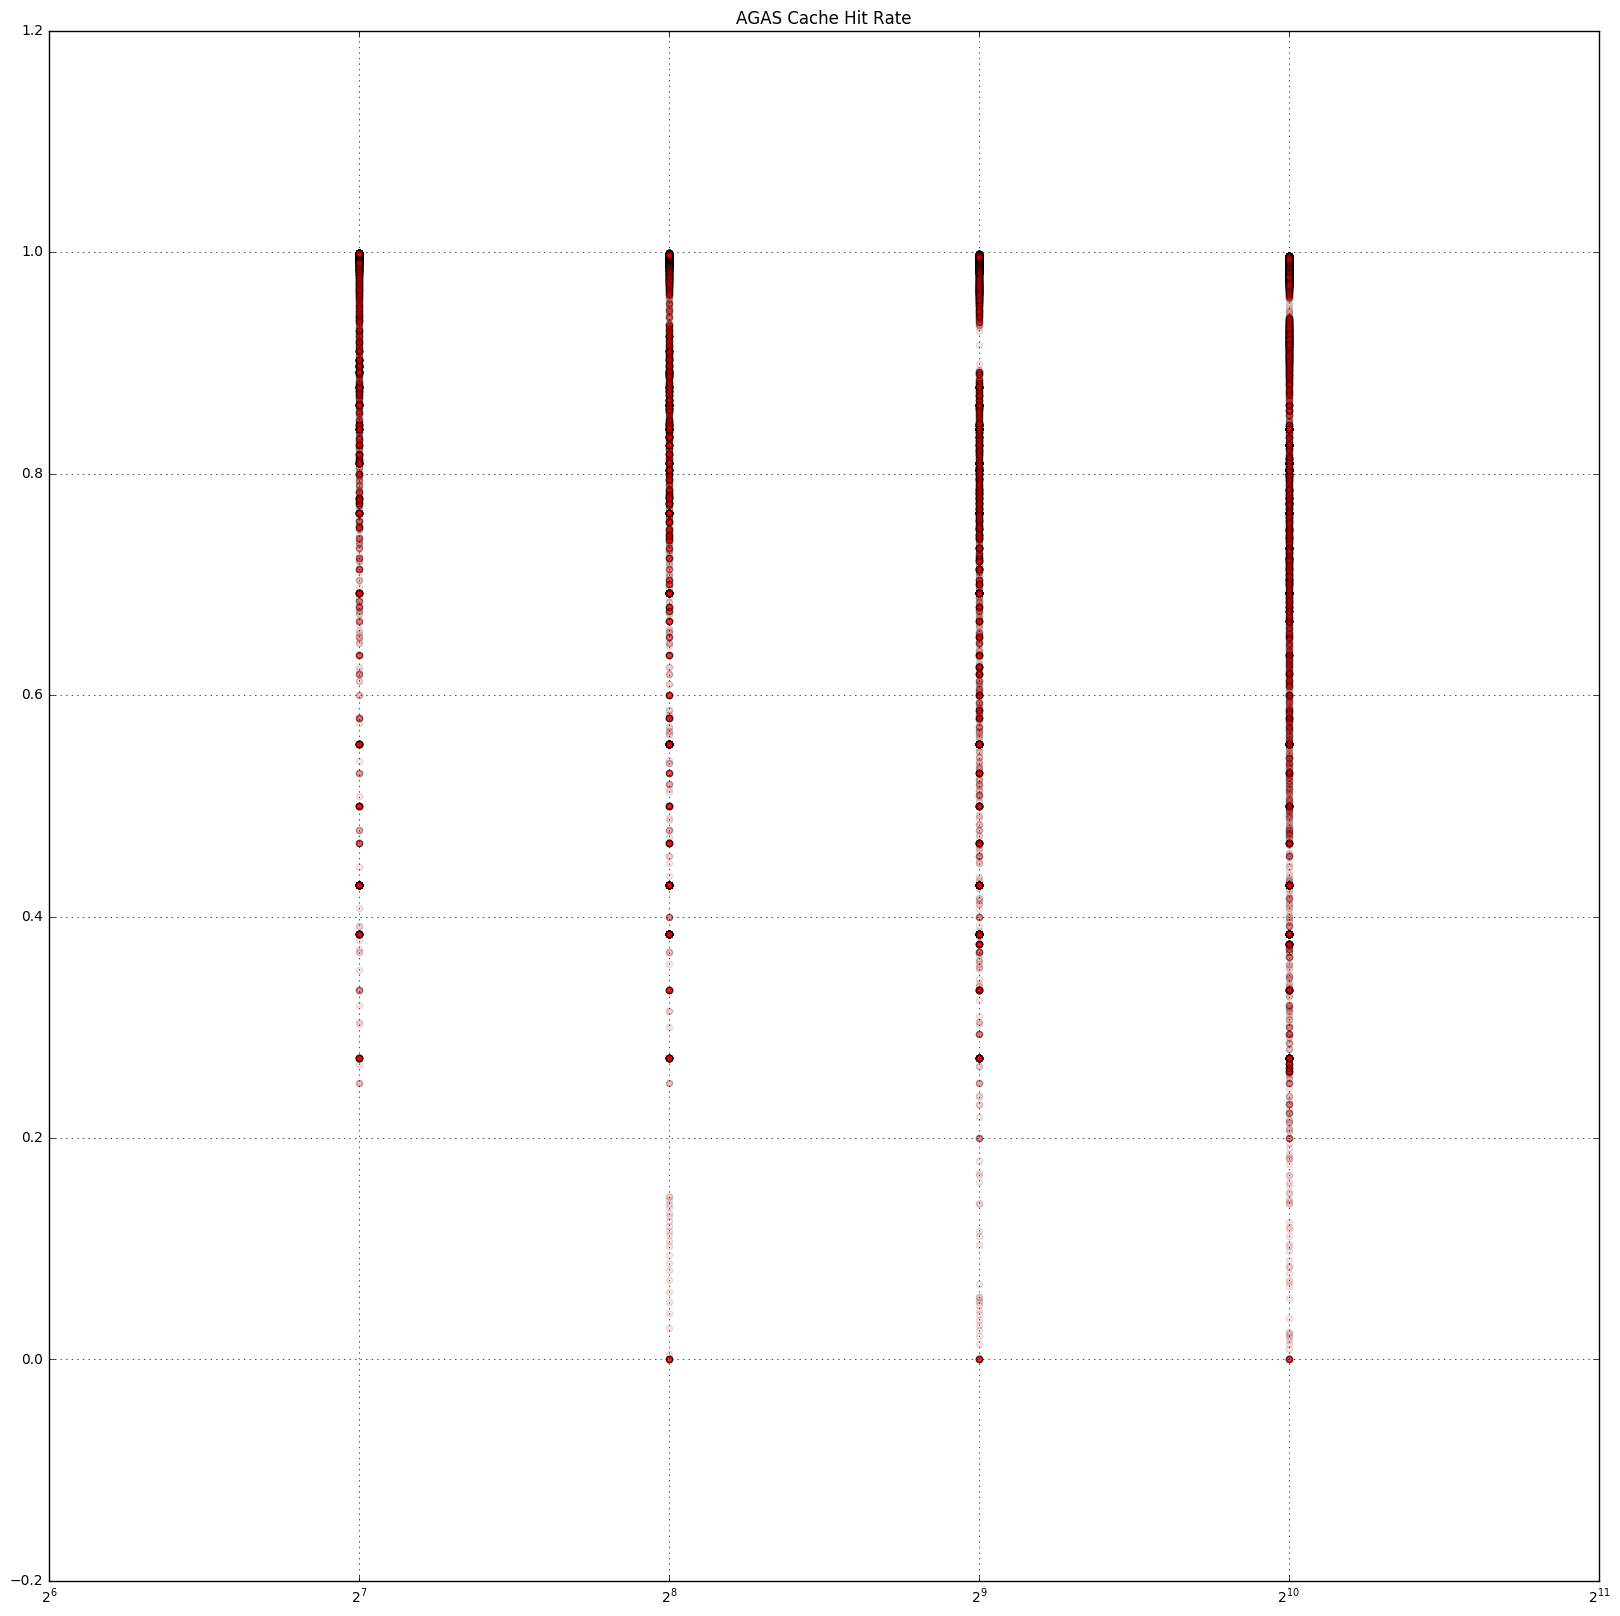

In [14]:
plt.figure(figsize=(20, 20))
plt.scatter([x[0] for x in d], f, c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Hit Rate')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Insert Entry

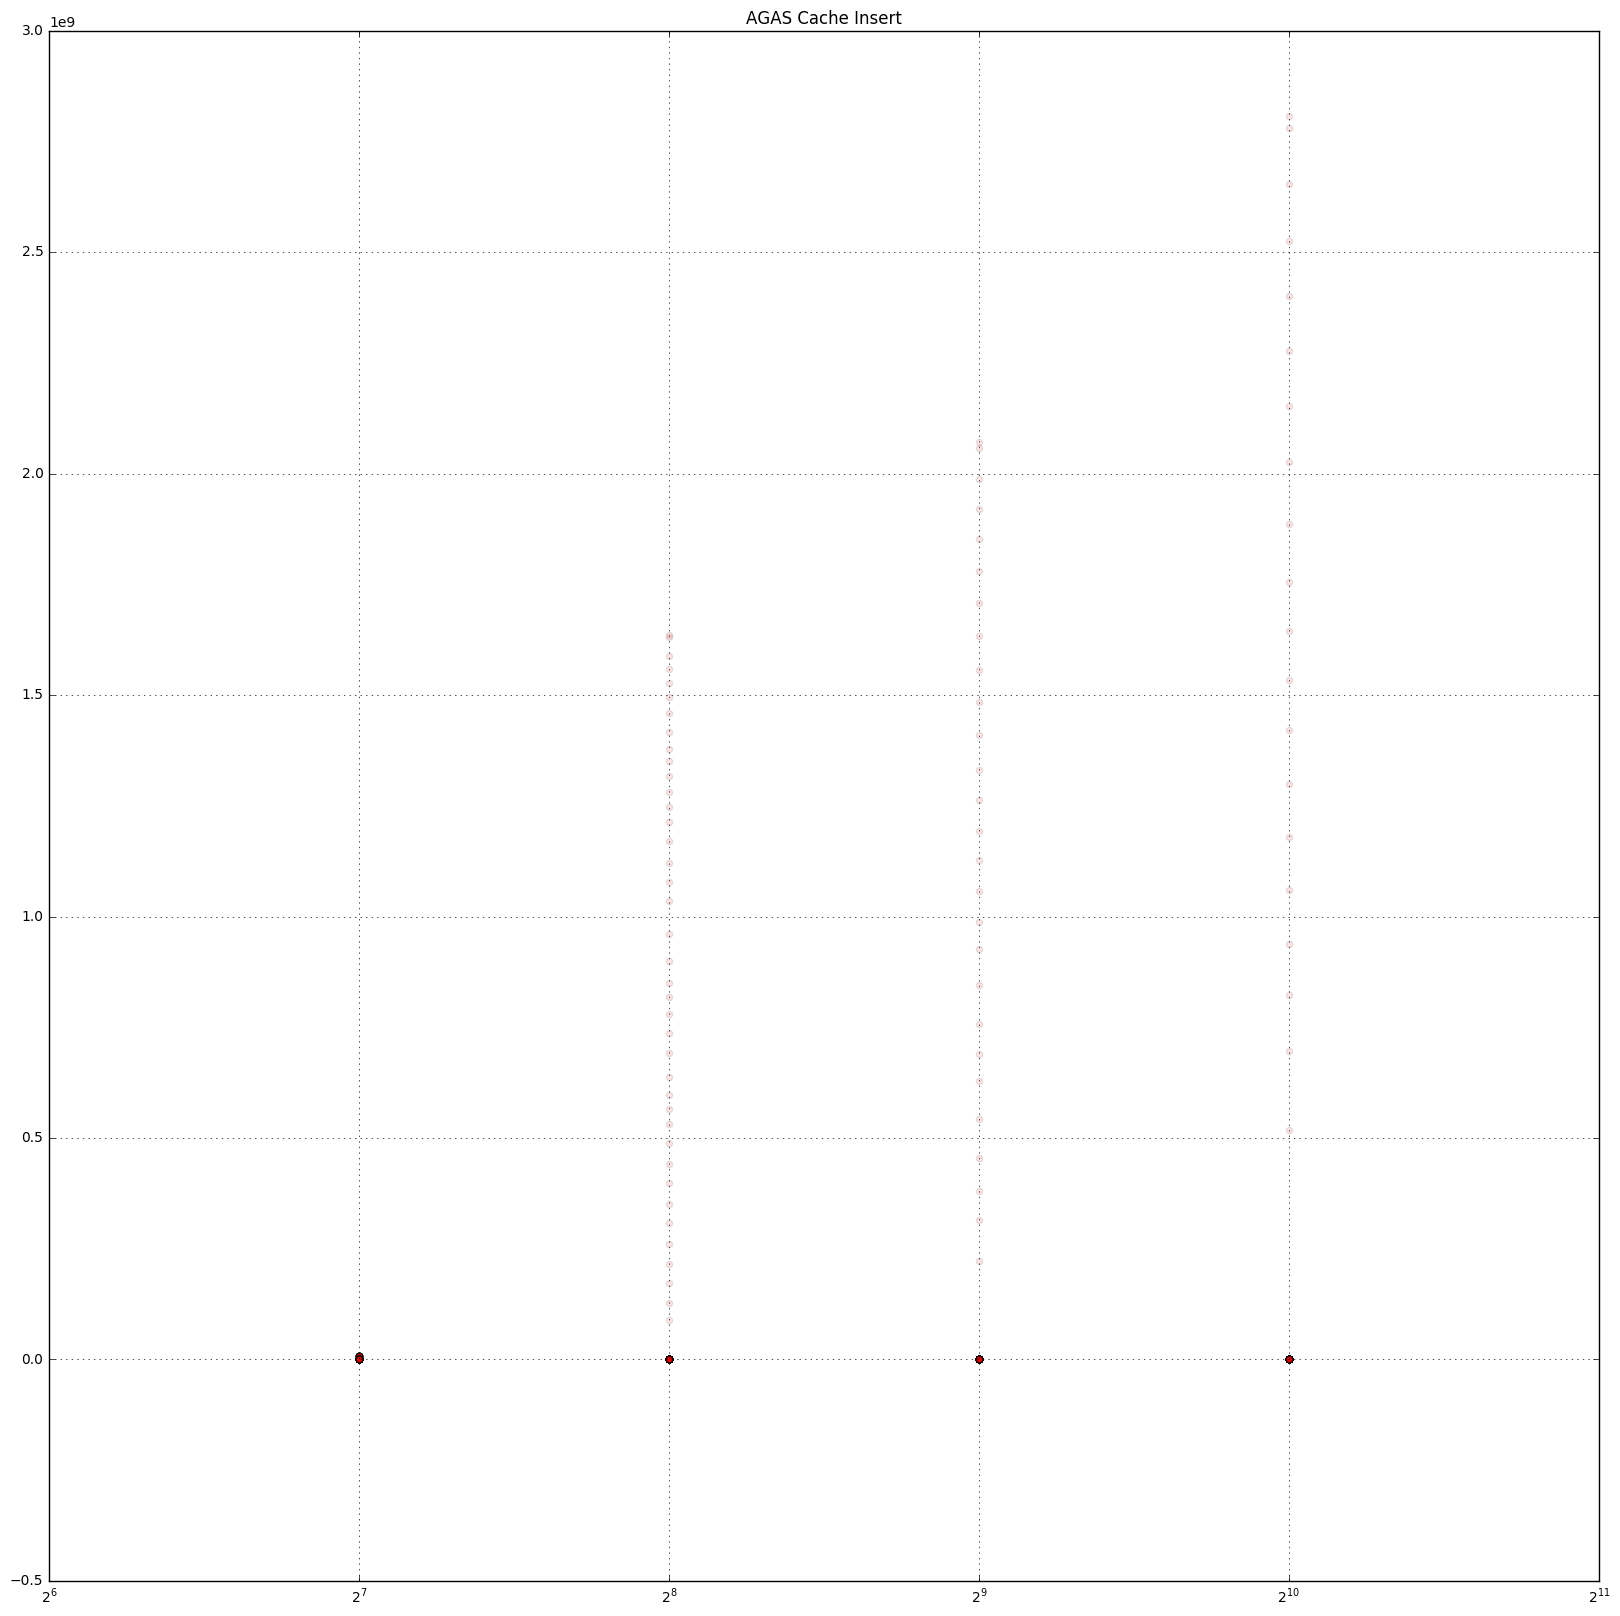

In [34]:
plt.figure(figsize=(20, 20))
d = [(x[1], x[6]) for x in dataset['agas']['cache/insert_entry']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Insert')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Erase Entry

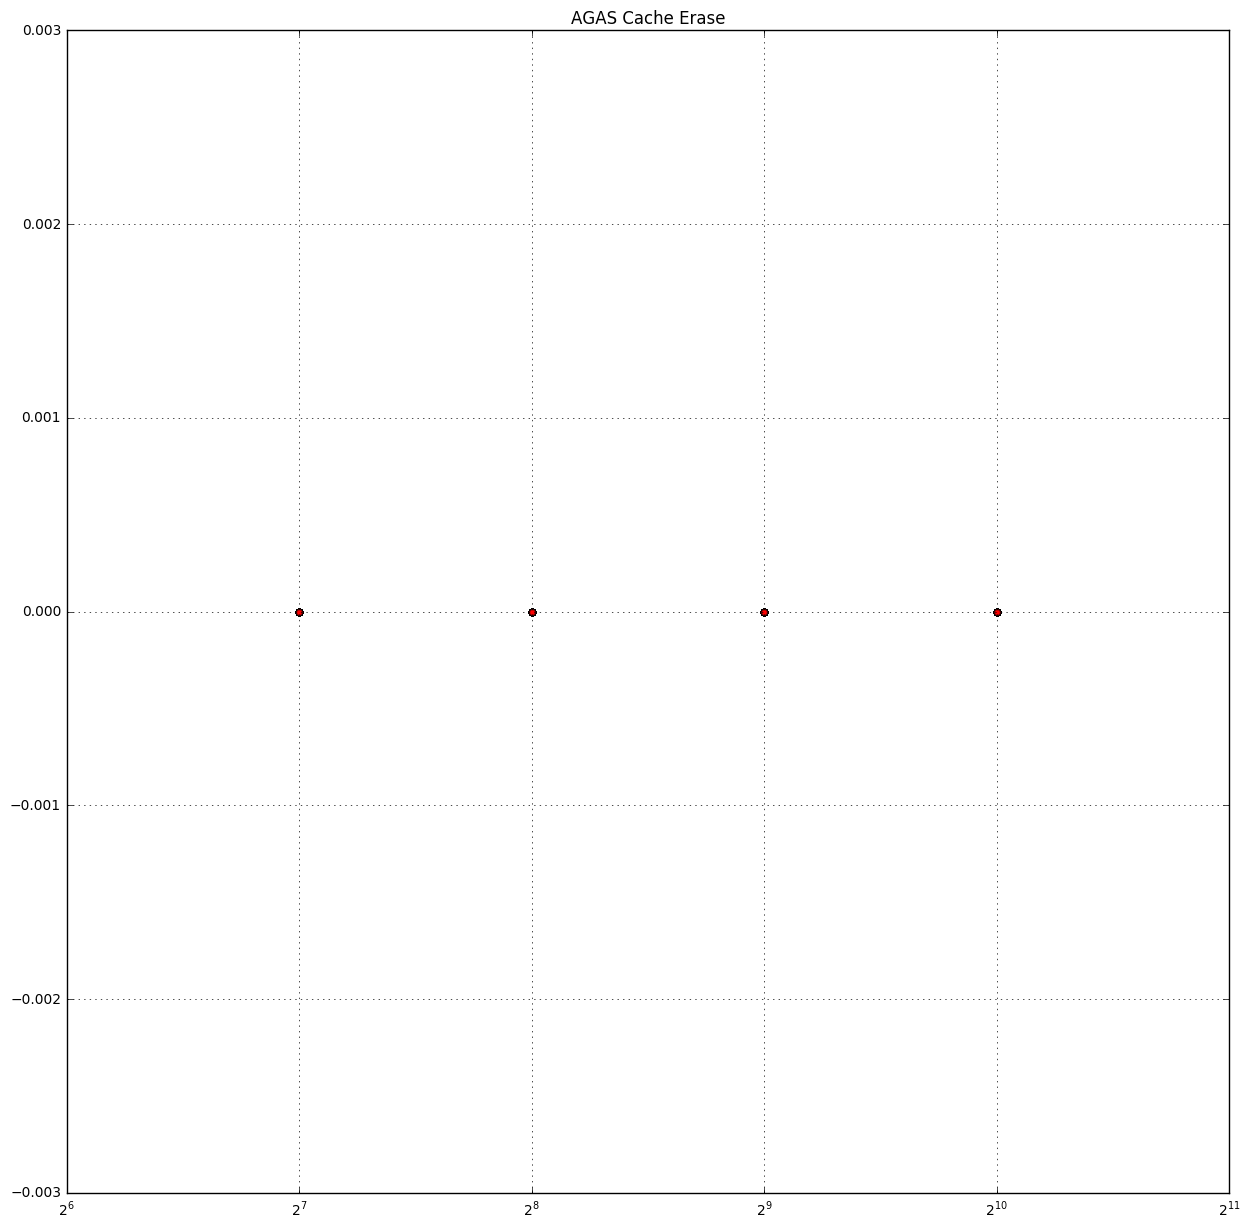

In [32]:
plt.figure(figsize=(15, 15))
d = [(x[1], x[6]) for x in dataset['agas']['cache/erase_entry']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Erase')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Get Entry

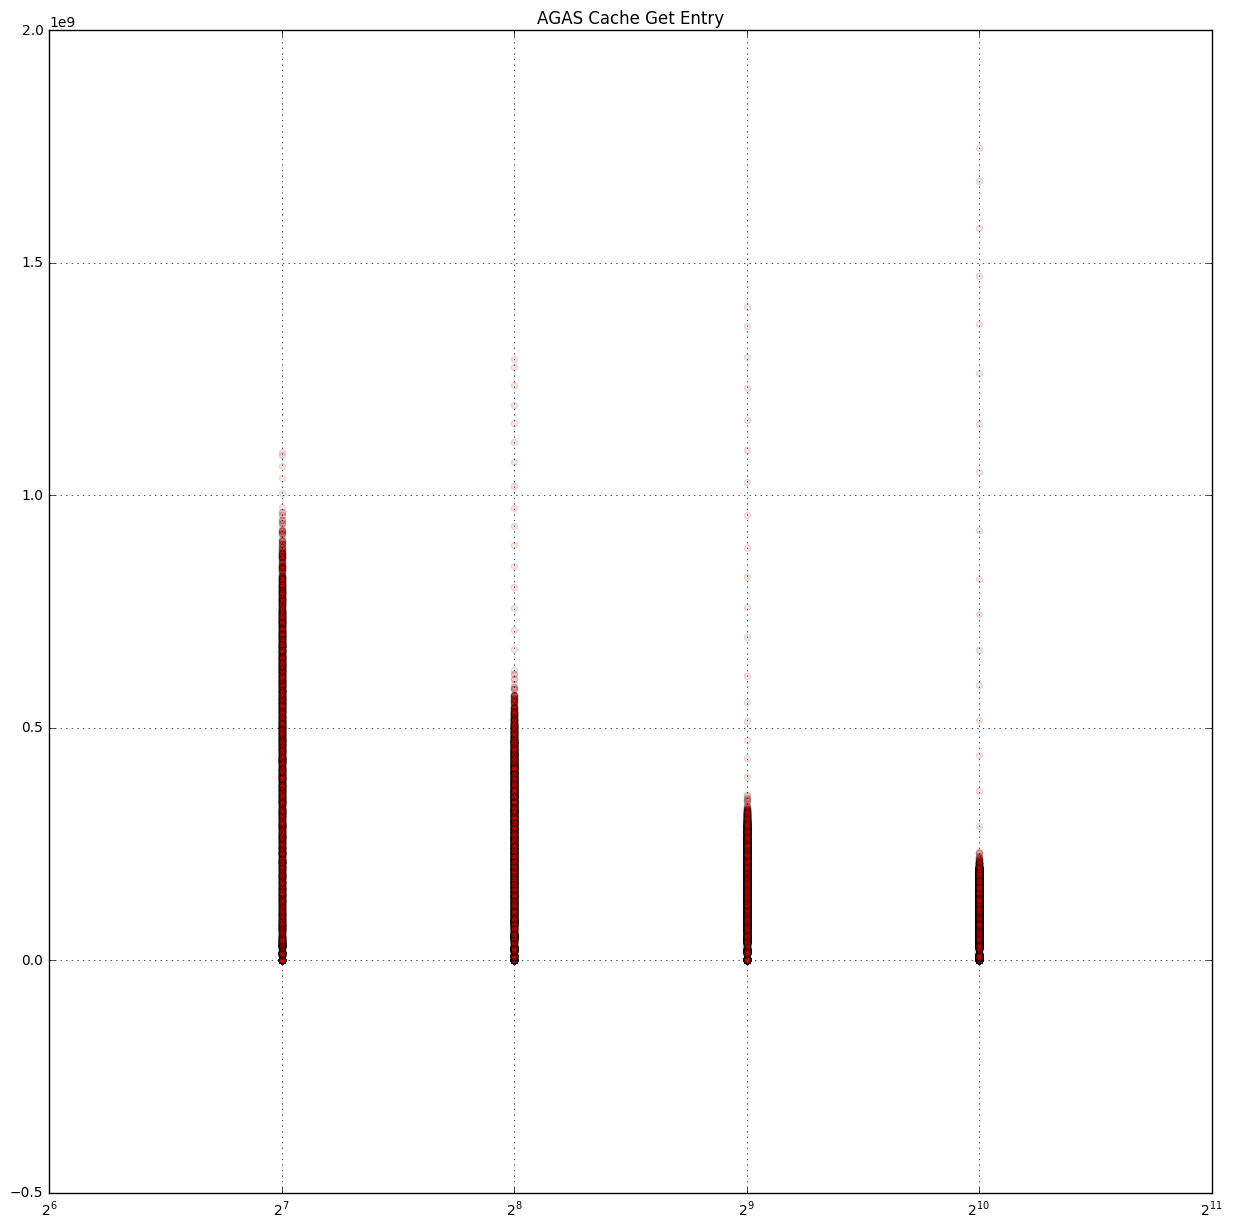

In [31]:
plt.figure(figsize=(15, 15))
d = [(x[1], x[6]) for x in dataset['agas']['cache/get_entry']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Get Entry')
plt.xscale('log', basex=2)

[^ TOC ^](#Counters)

### Update Entry

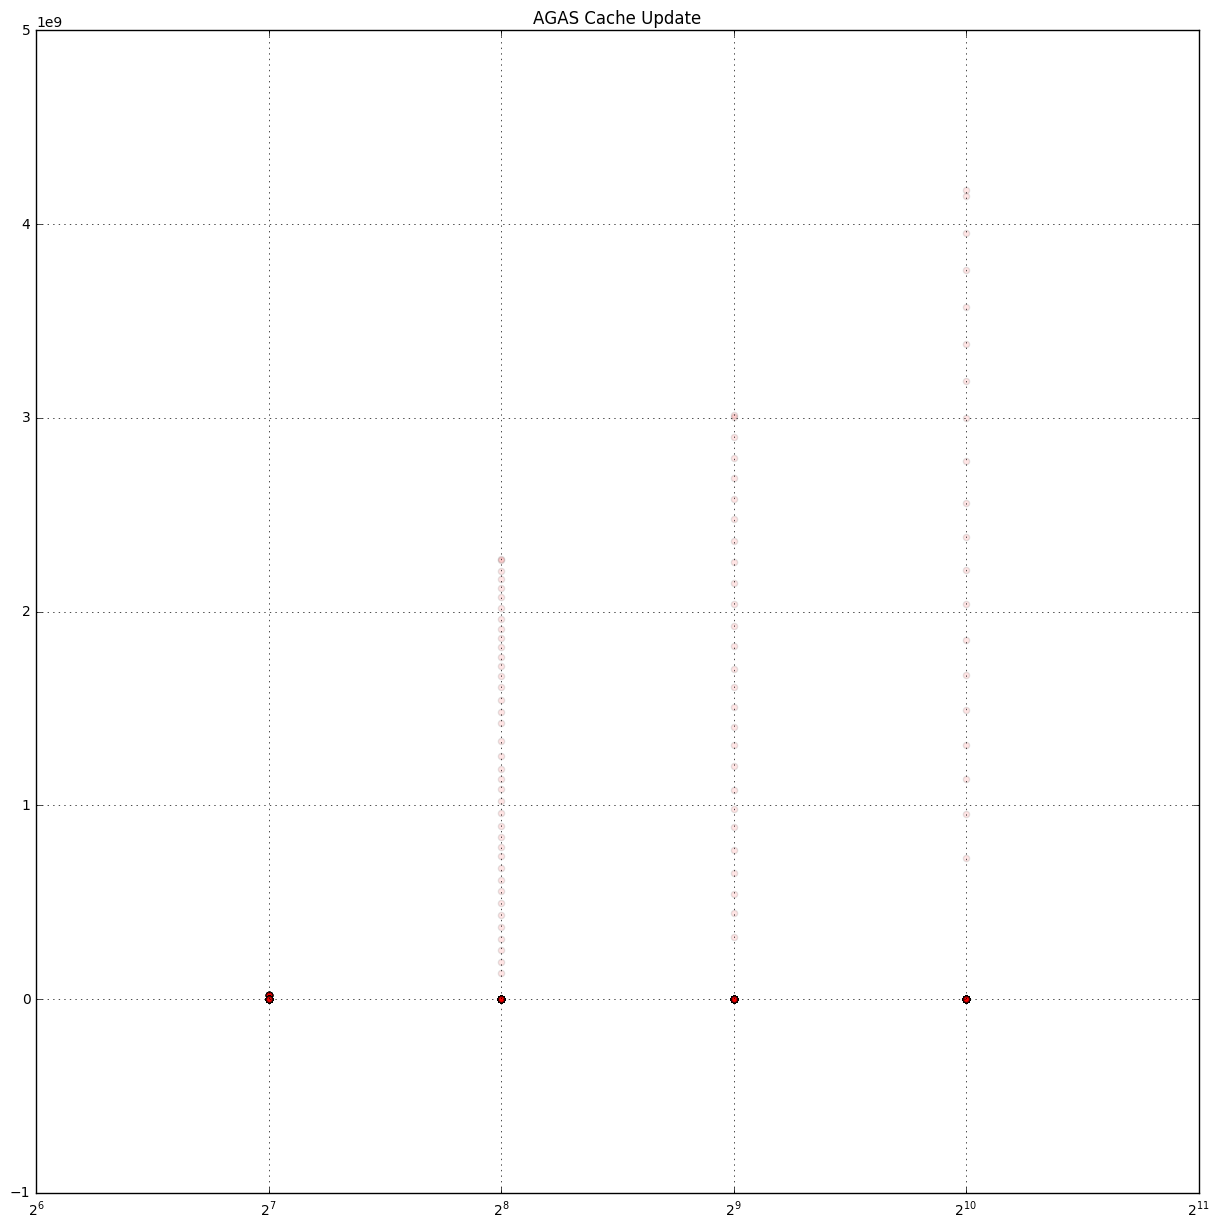

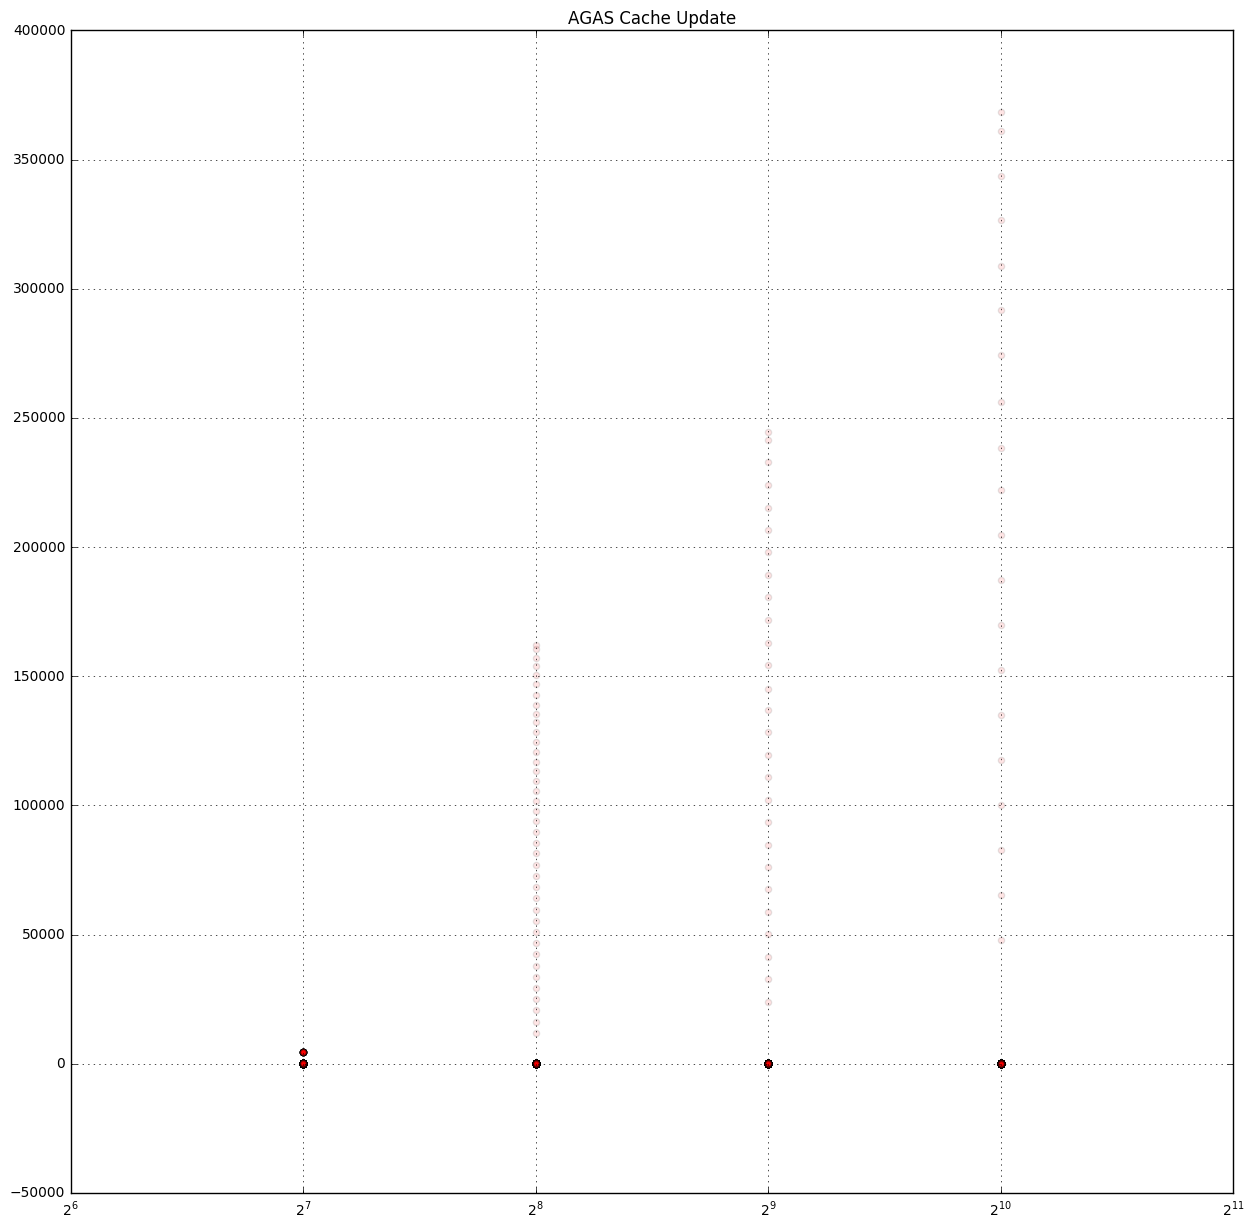

In [35]:
plt.figure(figsize=(15, 15))
d = [(x[1], x[6]) for x in dataset['agas']['cache/update_entry']['time']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Update')
plt.xscale('log', basex=2)

plt.figure(figsize=(15, 15))
d = [(x[1], x[6]) for x in dataset['agas']['cache/update_entry']['count']]

plt.scatter([x[0] for x in d], [x[1] for x in d], c='r', alpha=.1)
plt.grid(True)
plt.title('AGAS Cache Update')
plt.xscale('log', basex=2)

---

# Miscellaneous

### Save Dataset to disk

In [85]:
import json

In [130]:
with open('dataset.json', 'w') as fd:
    json.dump(dataset, fd, indent=4)

[^ TOC ^](#Counters)